# Packages

In [1]:
import plotly.express as px
import pandas as pd
from google.cloud import bigquery
import numpy as np
from datetime import time, timedelta, datetime
import math 
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ipywidgets
import statsmodels.stats.weightstats as sw
from statsmodels.stats.proportion import test_proportions_2indep
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
from google.cloud import bigquery
from scipy.stats import norm
from scipy import stats
pd.options.display.float_format = "{:,.2f}".format
from scipy.stats import norm
from scipy import stats
import statsmodels.stats.weightstats as ws
import openpyxl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# from ambrosia.designer import Designer
# from ambrosia.tester import Tester
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from tqdm.notebook import tqdm


import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind
from scipy import stats
from statsmodels.stats.proportion import test_proportions_2indep
from typing import List, Tuple, Union

# df["Week"] = df["Date"].dt.to_period("W").dt.to_timestamp()

bigquery_client = bigquery.Client(project='analytics-dev-333113')


## Funtions

In [2]:
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {day} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    for date in daterange:
        print(f"Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                          )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                          )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                          )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                          )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                          )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                          )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                          )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                      )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                      )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                  )

        print('DataFrame is written to Excel File successfully.')

def get_minimal_determinable_effect(std, sample_size, alpha, beta):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

def get_sample_size_abs(epsilon, std, alpha, beta):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

def estimate_errors(group_generator, effect_add_type, effect, alpha):
    pvalues_aa = []
    pvalues_ab = []
    for a_metric_values, b_metric_values in group_generator:
        pvalues_aa.append(get_ttest_pvalue(a_metric_values, b_metric_values))
        b_metric_values_with_effect = b_metric_values.copy()
        if effect_add_type == 'all_percent':
            b_metric_values_with_effect *= 1 + effect / 100
        elif effect_add_type == 'all_const':
            b_metric_values_with_effect += b_metric_values_with_effect.mean() * effect / 100
        pvalues_ab.append(get_ttest_pvalue(a_metric_values, b_metric_values_with_effect))
    first_type_error = np.mean(np.array(pvalues_aa) < alpha)
    second_type_error = np.mean(np.array(pvalues_ab) >= alpha)
    return pvalues_aa, pvalues_ab, first_type_error, second_type_error

def srm_pivot(df):
    
    df_new_control = []
    df_new_variant = []
    
    for row in df:
        total = df.Control + df.Variant
        control = df.Control / total
        variant = df.Variant / total
        df_new_control.append(control)
        df_new_variant.append(variant)
        
    control_x = df_new_control[1]

    variant_x = df_new_variant[1]
    
    df_pivot_new = pd.DataFrame()
    
    df_pivot_new['Date'] = pd.to_datetime(df['date']).dt.date
    df_pivot_new['Control'] = df.Control
    df_pivot_new['Variant'] = df.Variant
    df_pivot_new['Total'] = df.Variant + df.Control
    
    df_pivot_new['Control_%'] = control_x
    df_pivot_new['Variant_%'] = variant_x
    
    df_pivot_new['Expected'] = (df.Control + df.Variant)/2
    
    chi_f = []
    chi_p = []
    
    for index, row in df_pivot_new.iterrows():
        control_x_x = row.Control
        variant_x_x = row.Variant
        
        observed_x = (row.Control, row.Variant)
        expected_x = (row.Control + row.Variant) / 2
        
        chi = st.chisquare(observed_x, f_exp = expected_x)
        
        chi_f.append(chi[0])
        chi_p.append(round(chi[1],20))
        
    df_pivot_new['chi_f'] = chi_f
    df_pivot_new['chi_p'] = chi_p
    
    
    df_plot_perc = df_pivot_new[['Date','Control_%', 'Variant_%']]
    
    dates = df_plot_perc['Date']
    
    plt.figure(figsize=(15,10))
    
    plot_perc = sns.lineplot(data = df_plot_perc)
    plot_perc.set_xticklabels(dates)
    plot_perc.set(ylim=(0.45, 0.55))
    
    df_plot_p = df_pivot_new[['Date','chi_p']]
    
    total_users_in_test = sum(df_pivot_new['Control']) + sum(df_pivot_new['Variant'])
    
    control = sum(df_pivot_new['Control']) / total_users_in_test
    variant = sum(df_pivot_new['Variant']) / total_users_in_test
    
    print(100*round(control,5),"% users are in the Control group.")
    print(100*round(variant,5),"% users are in the Variant group")
    
    observed = [sum(df_pivot_new['Control']), sum(df_pivot_new['Variant'])]
    
    total_traffic = sum(observed)
    
    expected = [total_traffic/2, total_traffic/2]
    
    chi = st.chisquare(observed, f_exp = expected)
    
    if chi[1] < 0.01:
        print("Sample ratio mismatch (SRM) may be present")
    else:
        print("Sample ratio mismatch (SRM) probably not present")
        
    return(df_pivot_new) 

def ttest(df, metric_col, ab_group_col, pairs_list=[('A', 'B')], ci=False, corrected_ci=0.95):
    """
    Welch t-test. Возвращает датафрейм с результатами всех попарных сравнений.
    
    df: DataFrame, датафрейм, который содержит колонки с поюзерной метрикой и группой.
    metric_col: float,int, имя столбца с метрикой
    ab_group_col: str, имя столбца с группой
    pairs_list: list, список пар сравнений
    corrected_ci: float, доверительный интервал, подразумевается, что он уже скорректирован под множественное сравнение.
    
    return res_table, датафрейм с результатами
    """
    res_table = pd.DataFrame()
    for pair in pairs_list:
        sample0 = df.loc[df[ab_group_col]==pair[0], metric_col]
        sample1 = df.loc[df[ab_group_col]==pair[1], metric_col]
        m0 = sample0.mean()
        m1 = sample1.mean()
        v0 = sample0.std()**2
        v1 = sample1.std()**2
        n0 = len(sample0)
        n1 = len(sample1)
        t, pvalue, df_ = ws.ttest_ind(
            sample0, 
            sample1, 
            alternative='two-sided', 
            usevar='unequal'
        )
        se = np.sqrt(v0 / n0 + v1 / n1)
        delta = m1 - m0
        delta_per = (m1/m0-1)*100

        print(f'\nСравнение групп: {pair[0]} и {pair[1]}')
        print(f't-statistic: {t}, pvalue: {pvalue}, df: {df_}')
        print(f'delta = {delta}')
        print(f'delta,% = {delta_per}%')

        if ci:
            tail = (1 + corrected_ci) / 2
            lb = delta - stats.t.ppf(tail, df_)*se 
            ub = delta + stats.t.ppf(tail, df_)*se
            lb_per = lb*100/m0
            ub_per = ub*100/m0
            print(f'Дов. интервал для delta: ({lb},{ub})')
            print(f'Дов. интервал для delta, %: ({lb_per},{ub_per})')
            result = pd.DataFrame(
                np.array([pair[0], pair[1], t, df_, pvalue, m0, m1, n0, n1, delta, delta_per, lb, ub, lb_per, ub_per]).reshape(1,-1),
                columns=['group0', 'group1', 't_statistic', 'df', 'pvalue', 'mean0', 'mean1', 'sample0', 'sample1', 'diff_mean', 'diff_mean, %' ,'lb','ub', 'lb%', 'ub%']
            )
        else:
            result = pd.DataFrame(
                np.array([pair[0], pair[1], t, df_, pvalue, m0, m1, n0, n1, delta, delta_per]).reshape(1,-1),
                columns=['group0', 'group1', 't_statistic', 'df', 'pvalue', 'mean0', 'mean1', 'sample0', 'sample1', 'diff_mean', 'diff_mean, %']
            )
        res_table = pd.concat([res_table, result])
    return res_table

def prop_test_conversions(df, metric_col, ab_group_col, pairs_list=[('A', 'B')], corrected_ci=0.95):
    """
    Z-test для пропорций с коррекцией. Возвращает датафрейм с результатами всех попарных сравнений.

    df: DataFrame, датафрейм, который содержит колонки с поюзерной метрикой и группой.
    metric_col: float,int, имя столбца с метрикой
    ab_group_col: str, имя столбца с группой
    pairs_list: list, список пар сравнений
    corrected_ci: float, доверительный интервал, подразумевается, что он уже скорректирован под множественное сравнение.
    
    return res_table, датафрейм с результатами
    """
    res_table = pd.DataFrame()
    tail = (1 + corrected_ci) / 2
    for pair in pairs_list:
        num0 = df[df[ab_group_col]==pair[0]][metric_col].sum()
        denom0 = df[df[ab_group_col]==pair[0]][metric_col].count()
        num1 = df[df[ab_group_col]==pair[1]][metric_col].sum()
        denom1 = df[df[ab_group_col]==pair[1]][metric_col].count()
        p0 = num0 / denom0
        p1 = num1 / denom1
        r = test_proportions_2indep(
            num0, denom0, 
            num1, denom1, 
            value=0, 
            method='wald', 
            compare='diff', 
            alternative='two-sided',
            correction=True, 
            return_results=True
        )
        se = np.sqrt(r.variance)
        delta = p1 - p0
        delta_per = (p1/p0-1)*100
        lb = delta - stats.norm.ppf(tail)*se 
        ub = delta + stats.norm.ppf(tail)*se
        lb_per = lb*100/p0
        ub_per = ub*100/p0
        
        # Если мы оцениваем другие интервалы, нужна ли поправка?
        #lb_0 = stats.beta(num0, denum0-num0).ppf(ci[0])
        #ub_0 = stats.beta(num0, denum0-num0).ppf(ci[1])
        #lb_1 = stats.beta(num1, denum1-num1).ppf(ci[0])
        # ub_1 = stats.beta(num1, denum1-num1).ppf(ci[1])
        
        print(f'\nСравнение групп: {pair[0]} и {pair[1]}')
        print(f'statistic: {r.statistic}, pvalue: {r.pvalue}')
        print(f'delta = {delta}')
        print(f'delta,% = {delta_per}%')
        print(f'Дов. интервал для delta: ({lb},{ub})')
        print(f'Дов. интервал для delta, %: ({lb_per},{ub_per})')
        result = pd.DataFrame(
            np.array([pair[0], pair[1], r.statistic, r.pvalue, p0, p1, delta, delta_per, lb, ub, lb_per, ub_per]).reshape(1,-1),
            columns=['group0', 'group1', 'statistic','pvalue', 'mean0', 'mean1', 'diff_mean', 'diff_mean, %' ,'lb','ub', 'lb%', 'ub%']
        )
        res_table = pd.concat([res_table, result])
    return res_table

def method_benjamini_hochberg(pvalues, alpha=0.05):
    """Применяет метод Бенджамини-Хохберга для проверки значимости изменений.
    
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    Пример применения: df['Есть эффект?'] = method_benjamini_hochberg(df.pvalues)
    """
    m = len(pvalues)
    array_alpha = np.arange(1, m+1)
    array_alpha = alpha * array_alpha / m
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue <= alpha_:
            res[pvalue_index] = 1
        else:
            break
    res = res.astype(int)
    return res

def calculate_results(users_data, 
                      bernulli_metrics = [('map_view', 'payment'), ('map_view', 'save_adr'), ('save_adr', 'payment')],
                      common_metrics = ['paid_gmv', 'orders_cnt'],
                      common_metrics_per_paid_users = [('paid_gmv', 'arppu')],
                      ratio_metrics = [('paid_gmv', 'orders_cnt', 'aov')],
                      pairs_list = [(0, 1)],
                      alpha = 0.05):
    
    """
    Example:

    r = calculate_results(res, 
                  bernulli_metrics = [('has_city_view', 'has_ml_passed'),
                                      ('has_city_view', 'has_ride')],
                  common_metrics=[('cnt_rides')],
                  common_metrics_per_paid_users=[],
                  ratio_metrics=[],
                  pairs_list = [(0, 1)],
                  alpha = 0.05)

    r['result'] = (r['pvalue'] < 0.05)*1
    r['result_with_corr'] = method_benjamini_hochberg(r['pvalue'].values)

    r_renamed = r[['metric', 'n0', 'n1', 'mean0', 'mean1', 'diff_mean', 'diff_mean, %', 'lb', 'ub', 'lb%', 'ub%', 'pvalue', 'result', 'result_with_corr']].rename(columns={
            'metric':'Metric',
            'n0':'Sample Size А',
            'n1':'Sample Size B',
            'mean0':'Value А',
            'mean1':'Value B',
            'diff_mean':'Diff Absolute',
            'diff_mean, %':'Diff Percent %',
            'lb':'LB',
            'ub':'UB',
            'lb%':'LB%',
            'ub%':'UB%',
            'pvalue' : 'Pval',
            'result' : 'Result',
            'result_with_corr': 'Result Corrected'})

    r_renamed
    """
    
    results_arr = []
    
    # conversions
    
    if len(bernulli_metrics)>0:
    
        bernulli_metrics_arr = []

        for metric in bernulli_metrics:
        
            step1, step2 = metric

            metric_name = 'cr {} to {}'.format(step1, step2)

            print()
            print(metric_name)

            for pair in pairs_list:
                bernulli_metrics_stats = prop_test_conversions(users_data[(users_data[step1]==1)], step2, 
                                                        'has_treatment', pairs_list=[pair], corrected_ci=1 - alpha)

                bernulli_metrics_stats['metric'] = metric_name

                bernulli_metrics_stats['n0'] = users_data[(users_data[step1]==1)&
                                                        (users_data['has_treatment']==pair[0])][step1].sum()

                bernulli_metrics_stats['n1'] = users_data[(users_data[step1]==1)&
                                                        (users_data['has_treatment']==pair[1])][step1].sum()
                bernulli_metrics_arr.append(bernulli_metrics_stats)
    
        bernulli_metrics_df = pd.concat(bernulli_metrics_arr)
        bernulli_metrics_df[['mean0', 'mean1', 'diff_mean', 'lb', 'ub']]= bernulli_metrics_df[['mean0', 'mean1', 'diff_mean', 'lb', 'ub']]*100
        results_arr.append(bernulli_metrics_df)
    
    # common metrics
    
    common_metrics_arr = []
    
    if len(common_metrics)>0:
        
        for metric in common_metrics:

            print()
            print(metric)

            for pair in pairs_list:
                common_metrics_stats = ttest(users_data, metric, 'has_treatment', pairs_list=[pair],ci=True,  corrected_ci=1 - alpha)
                common_metrics_stats['metric'] = metric
                common_metrics_stats['n0'] = users_data[(users_data['has_treatment']==pair[0])][metric].count()
                common_metrics_stats['n1'] = users_data[(users_data['has_treatment']==pair[1])][metric].count()
                common_metrics_arr.append(common_metrics_stats)
        
        common_metrics_df = pd.concat(common_metrics_arr).rename(columns = {'t_statistic':'statistic'})
        common_metrics_df.drop(columns=['df'], axis=1, inplace=True)
        results_arr.append(common_metrics_df)

    common_metrics_arr = []

    if len(common_metrics_per_paid_users)>0:
    
        for metric_info in common_metrics_per_paid_users:

            metric, metric_name = metric_info

            print()
            print(metric_name)

            for pair in pairs_list:
                common_metrics_per_paid_users_stats = ttest(users_data[users_data[metric]!=0], metric, 'has_treatment', pairs_list=[pair],ci=True,  corrected_ci=1 - alpha)

                common_metrics_per_paid_users_stats['metric'] = metric_name

                common_metrics_per_paid_users_stats['n0'] = users_data[(users_data[metric]!=0)&
                                                                    (users_data['has_treatment']==pair[0])][metric].count()
                common_metrics_per_paid_users_stats['n1'] = users_data[(users_data[metric]!=0)&
                                                                    (users_data['has_treatment']==pair[1])][metric].count()
                common_metrics_arr.append(common_metrics_per_paid_users_stats)

        common_metrics_df = pd.concat(common_metrics_arr).rename(columns = {'t_statistic':'statistic'})
        common_metrics_df.drop(columns=['df'], axis=1, inplace=True)
        
        results_arr.append(common_metrics_df)
        
    # ration metrics
    
    if len(ratio_metrics)>0:
        ratio_metrics_arr = []

        for metric_info in ratio_metrics:

            nom_col, denom_col, metric_name = metric_info

            print()
            print(metric_name)

            for pair in pairs_list:
                ratio_metrics_stats = ttest_delta(users_data[users_data[denom_col]!=0], nom_col, denom_col, 
                                        'has_treatment', pairs_list=[pair], ci=True, corrected_ci=1 - alpha)

                ratio_metrics_stats['metric'] = metric_name

                ratio_metrics_stats['n0'] = users_data[(users_data[denom_col]!=0)&
                                                        (users_data['has_treatment']==pair[0])][denom_col].count()

                ratio_metrics_stats['n1'] = users_data[(users_data[denom_col]!=0)&
                                                    (users_data['has_treatment']==pair[1])][denom_col].count()

                ratio_metrics_arr.append(ratio_metrics_stats)

        ratio_metrics_df = pd.concat(ratio_metrics_arr).rename(columns = {'t_statistic':'statistic'})
        ratio_metrics_df[['mean0', 'mean1', 'diff_mean', 'lb', 'ub']]= ratio_metrics_df[['mean0', 'mean1', 'diff_mean', 'lb', 'ub']]*100

        results_arr.append(ratio_metrics_df)
    
    results_data = pd.concat(results_arr).reset_index(drop=True)
    
    return results_data

# Matching process

### Choosing the cities

In [ ]:
df_matching_city = read_bq("""
SELECT t1.city_id,
       city.city_name,
       city.country_name,
       IF(t1.city_id IN (4228, 4261, 4517, 833, 4269, 5568, 5575, 4199, 4200, 4153, 4530, 4755, 4559, 4197), 1,
          0) AS                                          segment,
       SUM(rides_count)                                  rides_count,
       SUM(orders_count)                                 orders_count,
       SUM(tenders_count)                                tenders_count,
       SUM(bid_count)                                    bid_count,
       SUM(rides_count_from_feed)                        rides_count_from_feed,
       SUM(rides_count_from_sn)                          rides_count_from_sn,
       SUM(gmv_clean_usd)                                gmv,
       SUM(orders_with_driver_arrived_late_count)        orders_with_driver_arrived_late_count,
       SUM(orders_with_driver_arrived_early_count)       orders_with_driver_arrived_early_count,
       SUM(pass_with_third_ride_count)                   pass_with_third_ride_count,
       SUM(rides_count_from_autobid)                     rides_count_from_autobid,
       AVG(ETA_sum)                                      avg_eta,
       AVG(RTA_sum)                                      avg_rta,
       SUM(reorders_count)                               reorders_count,
       SUM(canceled_arrived_orders_count)                canceled_arrived_orders_count,
       SUM(canceled_started_orders_count)                canceled_started_orders_count,
       SAFE_DIVIDE(SUM(gmv_clean_usd), SUM(rides_count)) avg_ride_price
FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
         JOIN (SELECT DISTINCT city_id,
                               city_name,
                               country_id,
                               country_name
               FROM indriver-e6e40.heap.vw_macroregion_mapping
               WHERE country_id IN (22, 11, 24, 12, 10)) city
              ON t1.city_id = city.city_id
WHERE 1 = 1
  AND user_type = 'pass'
  AND metric_date_utc BETWEEN '2024-08-01' AND '2024-11-30'
GROUP BY 1, 2, 3, 4
""")

df_matching_city.head()

In [ ]:
list(df_matching_city.drop(['city_name', 'country_name', 'city_id'], axis=1))

In [ ]:
import numpy as np

def euclidean_distance(metrics1, metrics2):
    return np.round(np.sqrt(np.sum((np.array(metrics1) - np.array(metrics2)) ** 2)), 2)

iterations = 1000
set_distance = 9999999999

for i in tqdm(range(iterations)):
    
    control_data = df_matching_city[(df_matching_city['rides_count'] > 100000)&(df_matching_city['segment'] == 0)].sample(9)
    test_data = df_matching_city[df_matching_city['segment'] == 1]

    vector1=[]
    vector2=[]
    for feature in list(df_matching_city.drop(['city_name', 'city_id', 'country_name'], axis=1)):
        vector1.append(control_data[feature].mean())
        vector2.append(test_data[feature].mean())
    
    euclid_distance = euclidean_distance(vector1, vector2)
    
    if euclid_distance < set_distance:
        set_distance = euclid_distance
        control_final = control_data.copy()
        test_final = test_data.copy()


In [ ]:
list(control_final['city_id']), list(test_final['city_id'])

### Choosing the users

In [ ]:
df_matching_user = read_bq("""
WITH personal AS (SELECT id AS                                                          user_id,
                         MAX(IF(created IS NOT NULL, DATE_DIFF(CURRENT_DATE(), DATE(created), MONTH),
                                0))                                                     month_registration,
                         COALESCE(MAX(rating3), 5)                                      rating,
                         MAX(country_id)                                                country_id,
                         MAX(IF(avatarmedium IS NOT NULL AND avatarmedium != '', 1, 0)) avatar_flag,
                         MAX(IF(banned IS NULL, 0, 1))                                  bans_flag
                  FROM dwh-storage-327422.personal_data.tbl_user_act
                  WHERE 1 = 1
                    AND mode = 'client'
                    AND city_id IN (4228, 4261, 4517, 833, 4269, 5568, 5575, 4199, 4200, 4153, 4530, 4755, 4559, 4197, 4258, 4379, 4225, 4542, 4373, 4142, 4242, 4144, 4300)
                  GROUP BY 1),
     triggered_users AS (SELECT DISTINCT t1.user_id
                         FROM indriver-e6e40.ods_banhammer.user_log_global t1
                         WHERE t1.created_at BETWEEN '2024-08-01' AND '2024-11-15'
                           AND t1.config_id IN (10521, 10522, 10523, 10524, 10561, 10562, 10563, 10560)),
     rides AS (SELECT user_id,
                      IF(t1.user_id IN (SELECT user_id FROM triggered_users), 1, 0) has_treatment,
                      SUM(rides_count)                                              rides_count,
                      SUM(orders_count)                                             orders_count,
                      SUM(tenders_count)                                            tenders_count,
                      SUM(bid_count)                                                bid_count,
                      SUM(rides_count_from_feed)                                    rides_count_from_feed,
                      SUM(rides_count_from_sn)                                      rides_count_from_sn,
                      SUM(gmv_clean_usd)                                            gmv,
                      SUM(orders_with_driver_arrived_late_count)                    orders_with_driver_arrived_late_count,
                      SUM(orders_with_driver_arrived_early_count)                   orders_with_driver_arrived_early_count,
                      SUM(pass_with_third_ride_count)                               pass_with_third_ride_count,
                      SUM(rides_count_from_autobid)                                 rides_count_from_autobid,
                      AVG(ETA_sum)                                                  avg_eta,
                      AVG(RTA_sum)                                                  avg_rta,
                      SUM(reorders_count)                                           reorders_count,
                      SUM(canceled_arrived_orders_count)                            canceled_arrived_orders_count,
                      SUM(canceled_started_orders_count)                            canceled_started_orders_count,
                      SUM(gmv_clean_usd) / SUM(rides_count)                         avg_ride_price
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
               WHERE 1 = 1
                 AND user_type = 'pass'
                 AND metric_date_utc BETWEEN '2024-08-01' AND '2024-11-15'
                 AND city_id IN (4228, 4261, 4517, 833, 4269, 5568, 5575, 4199, 4200, 4153, 4530, 4755, 4559, 4197, 4258, 4379, 4225, 4542, 4373, 4142, 4242, 4144, 4300)
               GROUP BY 1, 2
               HAVING rides_count >= 1)

SELECT p.*,
       r.* EXCEPT (user_id)
FROM rides r
         JOIN personal p ON r.user_id = p.user_id
""")

df_matching_user.head()

In [125]:
df_backup = df_matching_user.copy()

df_scaled = df_backup.copy()
df_scaled = df_scaled.dropna()
user_id_df = df_scaled['user_id']
has_treatment_df = df_scaled['has_treatment']
df_scaled = df_scaled.drop(['user_id', 'has_treatment'], axis=1)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled.values), index=df_scaled.index, columns=df_scaled.columns)

df_scaled['user_id'] = user_id_df
df_scaled['has_treatment'] = has_treatment_df
df_scaled = df_scaled.reset_index(drop=True)

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(df_scaled.drop(['user_id', 'has_treatment'], axis=1))
distances, indices = nbrs.kneighbors(df_scaled.drop(['user_id', 'has_treatment'], axis=1))




In [ ]:
matches = pd.DataFrame(indices).rename(columns={0:'index_main', 1:'index_found'})
matches['score'] = pd.DataFrame(distances)[1]

matches = matches.merge(df_scaled[['index', 'has_treatment', 'user_id']], left_on='index_main', right_on='index')
matches = matches.rename(columns={'has_treatment':'has_treatment_main'})

matches = matches.merge(df_scaled[['index', 'has_treatment', 'user_id']], left_on='index_found', right_on='index')
matches = matches.rename(columns={'has_treatment':'has_treatment_found'})

matches = matches.rename(columns={'user_id_x':'user_id_main'})
matches = matches.rename(columns={'user_id_y':'user_id_found'})

matches = matches.drop(['index_x', 'index_y'], axis=1)

matches = matches.loc[matches['has_treatment_main']!=matches['has_treatment_found']]

# matches = matches[matches['score']<=4]

main = matches[['user_id_main', 'has_treatment_main']].rename(columns={'user_id_main':'user_id', 'has_treatment_main':'has_treatment'})
found = matches[['user_id_found', 'has_treatment_found']].rename(columns={'user_id_found':'user_id', 'has_treatment_found':'has_treatment'})
split = pd.concat([main, found])

split.groupby('user_id', as_index=False).agg({'has_treatment':'max'}).groupby('has_treatment').count()



### Checking the chart on the same metrics to make sure that there is no difference

In [ ]:
df_checking_match = read_bq("""
WITH personal AS (SELECT id AS                                                          user_id,
                         MAX(IF(created IS NOT NULL, DATE_DIFF(CURRENT_DATE(), DATE(created), MONTH),
                                0))                                                     month_registration,
                         COALESCE(MAX(rating3), 5)                                      rating,
                         MAX(country_id)                                                country_id,
                         MAX(IF(avatarmedium IS NOT NULL AND avatarmedium != '', 1, 0)) avatar_flag,
                         MAX(IF(banned IS NULL, 0, 1))                                  bans_flag
                  FROM dwh-storage-327422.personal_data.tbl_user_act
                  WHERE 1 = 1
                    AND mode = 'client'
                    AND city_id IN
                        (4228, 4261, 4517, 833, 4269, 5568, 5575, 4199, 4200, 4153, 4530, 4755, 4559, 4197, 4258, 4379,
                         4225, 4542, 4373, 4142, 4242, 4144, 4300)
                  GROUP BY 1),
     triggered_users AS (SELECT DISTINCT t1.user_id
                         FROM indriver-e6e40.ods_banhammer.user_log_global t1
                         WHERE t1.created_at BETWEEN '2024-08-01' AND '2024-11-30'
                           AND t1.config_id IN (10521, 10522, 10523, 10524, 10561, 10562, 10563, 10560)),
     rides AS (SELECT metric_date_utc AS date,
                      user_id,
                      SUM(rides_count)   rides_count,
                      SUM(orders_count)  orders_count,
                      SUM(gmv_clean_usd) gmv,
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
               WHERE 1 = 1
                 AND user_type = 'pass'
                 AND metric_date_utc BETWEEN '2024-11-20' AND '2024-12-20'
                 AND city_id IN
                     (4228, 4261, 4517, 833, 4269, 5568, 5575, 4199, 4200, 4153, 4530, 4755, 4559, 4197, 4258, 4379,
                      4225, 4542, 4373, 4142, 4242, 4144, 4300)
               GROUP BY 1, 2
               HAVING rides_count >= 1)

SELECT p.*,
       r.* EXCEPT (user_id)
FROM rides r
         JOIN personal p ON r.user_id = p.user_id
""")

df_checking_match.head()

In [80]:
df_dynamics = df_checking_match.merge(split, on = 'user_id')

In [ ]:
df_dynamics.head()

In [85]:
df_dynamics = df_dynamics.groupby(['has_treatment'], as_index=False)['rides_count', 'gmv', 'orders_count'].mean()

In [ ]:
df_dynamics

In [ ]:
metrics = ['gmv', 'rides_count', 'orders_count']

for metric in metrics:
    fig = px.line(df_dynamics
                , x='date'
                , y=metric
                , color='has_treatment'
                , title=f"Key metric by users / {metric}"
                , width=1400, height=600
                )

    fig.update_traces(textposition="top center")

    fig.update_layout(
                    xaxis_title="Dates"
                , yaxis_title="Incident rate"
    )


    fig.show()

# Experiment design in certain cities

### MDE, Sample size, Period for each city

In [40]:
# Number of rides by users with incidents 
df_rides = read_bq("""
WITH rides AS (SELECT user_id,
                      user_type,
                      t1.country_id,
                      t2.country_name,
                      t1.city_id,
                      t2.city_name,
                      SUM(rides_count)                AS rides_counts,
                      ROUND(SUM(rides_count) / 30, 2) AS avg_by_driver
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                        JOIN indriver-bi.heap.vw_macroregion_mapping t2
                             ON t1.city_id = t2.city_id
               WHERE metric_date_utc BETWEEN DATE_ADD(CURRENT_DATE()
                   , INTERVAL - 31 DAY)
                   AND DATE_ADD(CURRENT_DATE()
                       , INTERVAL - 1 DAY)
                 AND user_type = 'pass'
               GROUP BY 1, 2, 3, 4, 5, 6),
     incidents AS (SELECT incident_date
                        , redmine_id
                        , driver_id
                        , city_id
                        , city_name
                        , category
                   FROM (SELECT redmine_id
                              , incident_date
                              , vertical
                              , aggressor
                              , incident_type
                              , category
                              , city_id
                              , city_name
                              , pass_id
                              , driver_id
                         FROM indriver-bi.safety.vw_safety_incidents_detail
                         WHERE aggressor = 'Driver'
                           AND incident_date BETWEEN DATE_ADD(CURRENT_DATE(), INTERVAL - 31 DAY) AND DATE_ADD(CURRENT_DATE(), INTERVAL - 1 DAY)
                           AND information_status = 'Confirmed'))
SELECT t1.*,
       IF(t2.redmine_id IS NOT NULL, 1, 0) AS has_incident
FROM rides t1
         LEFT JOIN incidents t2
                   ON t1.user_id = t2.driver_id
""")

# Users completed the checking process and made a first ride after processing
df_complete_and_ride = read_bq("""
WITH checks AS (SELECT user_id,
                       os_name,
                       event_dt_part,
                       city_id,
                       country_id,
                       city_name,
                       country_name,
                       fulfilled_flow,
                       MIN(IF(name = 'client.verification_start.show', client_time,
                              NULL)) AS banner_show,
                       MIN(IF(name = 'client.verification_start.click', client_time,
                              NULL)) AS banner_click,
                       MIN(IF(name = 'client.verification_flow_result_status.show'
                                  AND LOWER(status) = 'approve',
                              client_time,
                              NULL)) AS status,
                FROM (SELECT user_id,
                             name,
                             os_name,
                             event_dt_part,
                             TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                             t1.city_id,
                             t2.city_name,
                             t2.country_id,
                             t2.country_name,
                             IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                    OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                    OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                             JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status
                      FROM indriver-e6e40.emart.swrve_event t1
                               JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                    ON
                                        t1.city_id = t2.city_id
                      WHERE 1 = 1
                        AND name IN (
                                     'client.verification_start.show',
                                     'client.verification_start.click',
                                     'client.verification_flow_result_status.show'
                          )
                        AND event_dt_part BETWEEN DATE_ADD(CURRENT_DATE(), INTERVAL - 31 DAY) AND DATE_ADD(CURRENT_DATE(), INTERVAL - 1 DAY))
                WHERE fulfilled_flow = 'liveness'
                GROUP BY 1, 2, 3, 4, 5, 6, 7, 8),
     rides AS (SELECT order_uuid,
                      driver_id,
                      user_id,
                      city_id,
                      country_id,
                      status_order,
                      order_timestamp,
                      driverdone_timestamp,
                      driverstarttheride_timestamp,
                      created_date_order_part
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2024-11-01'
                 AND driverstarttheride_timestamp IS NOT NULL)
SELECT t1.user_id,
       t1.os_name,
       t1.event_dt_part,
       t1.city_id,
       t1.country_id,
       t1.city_name,
       t1.country_name,
       t1.fulfilled_flow,
       IF(t1.banner_show IS NOT NULL, 1, 0) AS banner_show,
       IF(t1.status IS NOT NULL, 1, 0)      AS got_status,
       IF(t2.user_id IS NOT NULL, 1, 0)     AS has_ride
FROM checks t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.user_id
                       AND t2.driverstarttheride_timestamp BETWEEN status AND DATE_ADD(status, INTERVAL + 1 DAY)
QUALIFY ROW_NUMBER() OVER (first_value) = 1
WINDOW first_value AS (
        PARTITION BY t1.user_id ORDER BY t2.driverstarttheride_timestamp
        )
""")

# How many users faced the bh checks and have been triggered by system
df_sample_size = read_bq("""
WITH banhammer AS (SELECT user_id,
                          city_id,
                          country_id,
                          DATE(created_at)                                             AS event_dt_part,
                          ARRAY_TO_STRING(ARRAY_AGG(CAST(config_id AS string)), ', ')  AS config_id,
                          ARRAY_TO_STRING(ARRAY_AGG(DISTINCT name), ', ')              AS name,
                          ARRAY_TO_STRING(ARRAY_AGG(CAST(created_at AS string)), ', ') AS created_at,
                          MAX(created_at)                                              AS last_created_at
                   FROM (SELECT DISTINCT t1.user_id,
                                         t1.city_id,
                                         t1.country_id,
                                         t1.config_id,
                                         t1.created_at,
                                         t2.name,
                                         t2.city_ids,
                         FROM indriver-e6e40.ods_banhammer.user_log_global t1
                                  JOIN indriver-e6e40.ods_banhammer.actions_configs_global t2
                                       ON t1.config_id = t2.id
                         WHERE t1.created_at >= '2024-11-13'
                           AND t1.config_id IN (10521, 10522, 10523, 10524))
                   GROUP BY 1, 2, 3, 4),
     liveness AS (SELECT user_id,
                         os_name,
                         event_dt_part,
                         city_id,
                         country_id,
                         city_name,
                         country_name,
                         fulfilled_flow,
                         MIN(IF(name = 'client.verification_start.show', client_time,
                                NULL)) AS banner_show,
                         MIN(IF(name = 'client.verification_start.click', client_time,
                                NULL)) AS banner_click,
                         MIN(IF(name = 'client.verification_flow_result_status.show' AND
                                LOWER(status) = 'approve',
                                client_time,
                                NULL)) AS status_result
                  FROM (SELECT user_id,
                               name,
                               os_name,
                               event_dt_part,
                               TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status
                        FROM indriver-e6e40.emart.swrve_event t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show',
                                       'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            )
                          AND event_dt_part >= '2024-11-13')
                  WHERE fulfilled_flow = 'liveness'
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8),
     orders AS (SELECT t1.city_id,
                       city_name,
                       metric_date_utc,
                       COUNT(user_id) AS total_users
                FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                         JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                              ON t1.city_id = t2.city_id
                WHERE metric_date_utc >= '2024-11-01'
                  AND user_type = 'pass'
                GROUP BY 1, 2, 3),
     joined AS
         (SELECT t1.*,
                 t2.user_id       AS live_user_id,
                 t2.os_name,
                 t2.event_dt_part AS live_event_dt_part,
                 t2.city_id       AS live_city_id,
                 t2.country_id    AS live_country_id,
                 t2.city_name,
                 t2.country_name,
                 t2.fulfilled_flow,
                 t2.banner_show,
                 t2.banner_click,
                 t2.status_result
          FROM banhammer t1
                   LEFT JOIN liveness t2
                             ON t1.user_id = t2.user_id
                                 AND banner_show >= last_created_at
          WHERE os_name IN ('android', 'ios')
          QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY status_result) = 1)
SELECT event_dt_part,
       DATE_TRUNC(event_dt_part, WEEK) AS weekly,
       COUNT(user_id)                  AS users,
       COUNT(banner_click)             AS banner_click,
       COUNT(status_result)            AS approved_liv
FROM joined
GROUP BY 1, 2
""")


# Cities for launching: (4228, 4261, 4517, 833, 4269, 5568, 5575, 4199, 4200, 4153, 4530, 4755, 4559, 4197)


In [41]:
df_sample_size = df_sample_size.sort_values('event_dt_part', ascending=True).iloc[2:-1]

one_day_traffic = int(df_sample_size['users'].mean())
one_week_traffic = int(df_sample_size.groupby('weekly', as_index=False)['users'].sum().mean())
two_week_traffic = one_week_traffic * 2
three_week_traffic = one_week_traffic * 3
one_month = one_day_traffic * 30

In [45]:
### Set parameters grid
effects = [1.01, 1.02, 1.03, 1.04, 1.05]  # MDE in percents
sizes = [one_week_traffic, two_week_traffic, three_week_traffic, one_month]  # Size of each group
first_type_errors = [0.01, 0.05]
second_type_errors = [0.2]

In [47]:
designer_target1 = Designer(dataframe=df_rides, metrics='rides_counts')
designer_target2 = Designer(dataframe=df_complete_and_ride, metrics='has_ride')
designer_guardrail1 = Designer(dataframe=df_rides, metrics='has_incident')
designer_guardrail2 = Designer(dataframe=df_complete_and_ride, metrics='got_status')

designer_target1.set_first_errors(first_type_errors)
designer_target1.set_second_errors(second_type_errors)
designer_target2.set_first_errors(first_type_errors)
designer_target2.set_second_errors(second_type_errors)
designer_guardrail1.set_first_errors(first_type_errors)
designer_guardrail1.set_second_errors(second_type_errors)
designer_guardrail2.set_first_errors(first_type_errors)
designer_guardrail2.set_second_errors(second_type_errors)

target1 = designer_target1.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)
target1['Metric'] = 'Number of rides by user in 30 days (Target)'

target2 = designer_target2.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)
target2['Metric'] = 'CR to first ride upon the check (Target)'

guard1 = designer_guardrail1.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)
guard1['Metric'] = 'CR to incident by driver (Guardrail)'

guard2 = designer_guardrail2.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)
guard2['Metric'] = 'CR to status approved (Guardrail)'



In [ ]:
pd.concat([target1, target2, guard2, guard1])

target_metric_power = designer_target2.run(
    to_design='power', 
    method='theory', 
    effects=effects, 
    sizes=sizes)
print(target_metric_power)


target_metric_size = designer_target2.run( # Calculation on target metric regarding effect sizes we're considering
    to_design='size', 
    method='theory',
    effects=effects)
print(target_metric_size)


# Summarizing (Causal Impact & Random sampling)

Chosen metrics: rides, orders, incidents, conversion to approve

### Random sampling

In [ ]:
df_metrics = read_bq("""
WITH liveness AS (SELECT user_id,
                         os_name,
                         event_dt_part,
                         city_id,
                         country_id,
                         city_name,
                         country_name,
                         fulfilled_flow,
                         MIN(IF(name = 'client.verification_start.show', client_time,
                                NULL)) AS banner_show,
                         MIN(IF(name = 'client.verification_start.click', client_time,
                                NULL)) AS banner_click,
                         MIN(IF(name = 'client.verification_flow_result_status.show' AND
                                LOWER(status) = 'approve',
                                client_time,
                                NULL)) AS status_result
                  FROM (SELECT user_id,
                               name,
                               os_name,
                               event_dt_part,
                               TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status
                        FROM indriver-e6e40.emart.swrve_event t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.show',
                                       'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            )
                          AND event_dt_part BETWEEN '2024-11-15' AND '2024-12-20')
                  WHERE fulfilled_flow = 'liveness'
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8),
     rides AS (SELECT user_id,
                      SUM(rides_count)   rides_count,
                      SUM(orders_count)  orders_count,
                      SUM(gmv_clean_usd) gmv,
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
               WHERE 1 = 1
                 AND user_type = 'pass'
                 AND metric_date_utc BETWEEN '2024-11-15' AND '2024-12-20'
               GROUP BY 1)
SELECT t1.user_id,
       t1.city_id,
       t1.country_id,
       t1.city_name,
       approved,
       rides_count,
       orders_count,
       gmv
FROM (SELECT user_id,
             city_id,
             country_id,
             city_name,
             MAX(IF((status_result IS NOT NULL), 1, 0)) AS approved
      FROM liveness t1
      GROUP BY 1, 2, 3, 4) t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.user_id
""")

df_metrics.head()

In [92]:
df_sample = split.copy()
df_random_sampling = df_metrics.merge(df_sample, on = 'user_id')
df_random_sampling = df_random_sampling.fillna(0)
df_random_sampling.groupby('has_treatment', as_index=False)['user_id'].count()

In [ ]:
p_values_avatar = [
        ttest_ind(np.random.choice(df_random_sampling[df_random_sampling['has_treatment'] == 1]['gmv'], size=64, replace=True),
                np.random.choice(df_random_sampling[df_random_sampling['has_treatment'] == 0]['gmv'], size=64, replace=True), equal_var=False)[1]
        for _ in tqdm(range(1000))
]

print(np.mean(p_values_avatar))

plot_pvalue_ecdf(p_values_avatar)

### Causal impact

In [84]:
df_result_causal = read_bq("""
WITH liveness AS (SELECT event_dt_part,
                         city_id,
                         city_name,
                         COUNT(status_result) AS approved_users
                  FROM (SELECT user_id,
                               os_name,
                               event_dt_part,
                               city_id,
                               country_id,
                               city_name,
                               country_name,
                               fulfilled_flow,
                               MIN(IF(name = 'client.verification_start.show', client_time,
                                      NULL)) AS banner_show,
                               MIN(IF(name = 'client.verification_start.click', client_time,
                                      NULL)) AS banner_click,
                               MIN(IF(name = 'client.verification_flow_result_status.show' AND
                                      LOWER(status) = 'approve',
                                      client_time,
                                      NULL)) AS status_result
                        FROM (SELECT user_id,
                                     name,
                                     os_name,
                                     event_dt_part,
                                     TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                                     t1.city_id,
                                     t2.city_name,
                                     t2.country_id,
                                     t2.country_name,
                                     IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                            OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                        JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                        LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                            OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                                     JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status
                              FROM indriver-e6e40.emart.swrve_event t1
                                       JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                            ON
                                                t1.city_id = t2.city_id
                              WHERE 1 = 1
                                AND name IN (
                                             'client.verification_start.show',
                                             'client.verification_start.click',
                                             'client.verification_flow_result_status.show'
                                  )
                                AND event_dt_part BETWEEN '2024-07-01' AND '2024-12-20')
                        WHERE fulfilled_flow = 'liveness'
                        GROUP BY 1, 2, 3, 4, 5, 6, 7, 8)
                  GROUP BY 1, 2, 3),
     rides AS (SELECT t1.city_id,
                      t2.city_name,
                      metric_date_utc,
                      SUM(rides_count)   rides_count,
                      SUM(orders_count)  orders_count,
                      SUM(gmv_clean_usd) gmv,
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                        JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                             ON
                                 t1.city_id = t2.city_id
               WHERE 1 = 1
                 AND user_type = 'pass'
                 AND metric_date_utc BETWEEN '2024-07-01' AND '2024-12-20'
               GROUP BY 1, 2, 3)
SELECT t1.city_id,
       t1.city_name,
       t1.metric_date_utc,
       t1.rides_count,
       t1.orders_count,
       t1.gmv,
       t2.approved_users
FROM rides t1
         LEFT JOIN liveness t2
                   ON t1.city_id = t2.city_id
                       AND t1.metric_date_utc = t2.event_dt_part
WHERE t1.city_id IN (4228, 4261, 4517, 833, 4269, 5568, 5575, 4199, 4200, 4153, 4530, 4755, 4559, 4197)
""")

df_result_causal.head()

,city_id,city_name,metric_date_utc,rides_count,orders_count,gmv,approved_users
0,4530,Brasília,2024-08-26,10089,21426,"36,169.40",130
1,4153,Salvador,2024-11-04,6795,20451,"25,963.10",206
2,5575,Curicó,2024-09-26,329,616,997.63,5
3,5575,Curicó,2024-07-12,403,815,"1,259.20",10
4,4197,Bogota,2024-08-30,91573,207323,"341,554.97",150


In [85]:
df_causal_test = df_result_causal.query("city_id in (4228, 4261, 4269, 4517, 833, 5568, 5575)")

df_causal_exp = df_result_causal.query("city_id in (4199, 4200, 4153, 4530, 4559)")

In [86]:
df_result_causal_group_test = df_causal_test.groupby(['metric_date_utc'], as_index=False)[['rides_count', 'orders_count', 'gmv', 'approved_users']].sum()
df_result_causal_group_test['metric_date_utc'] = pd.to_datetime(df_result_causal_group_test['metric_date_utc'])

df_result_causal_group_exp = df_causal_exp.groupby(['metric_date_utc'], as_index=False)[['rides_count', 'orders_count', 'gmv', 'approved_users']].sum()
df_result_causal_group_exp['metric_date_utc'] = pd.to_datetime(df_result_causal_group_exp['metric_date_utc'])

In [87]:
df_result_causal_group_test = df_result_causal_group_test.set_index('metric_date_utc') 
df_result_causal_group_exp = df_result_causal_group_exp.set_index('metric_date_utc') 

ts_pre_period_test = [pd.to_datetime(date) for date in ["2024-07-01", "2024-11-12"]] 
ts_post_period_test = [pd.to_datetime(date) for date in ["2024-11-13", "2024-12-20"]] 
ts_pre_period_exp = [pd.to_datetime(date) for date in ["2024-07-01", "2024-12-04"]] 
ts_post_period_exp = [pd.to_datetime(date) for date in ["2024-12-05", "2024-12-20"]] 

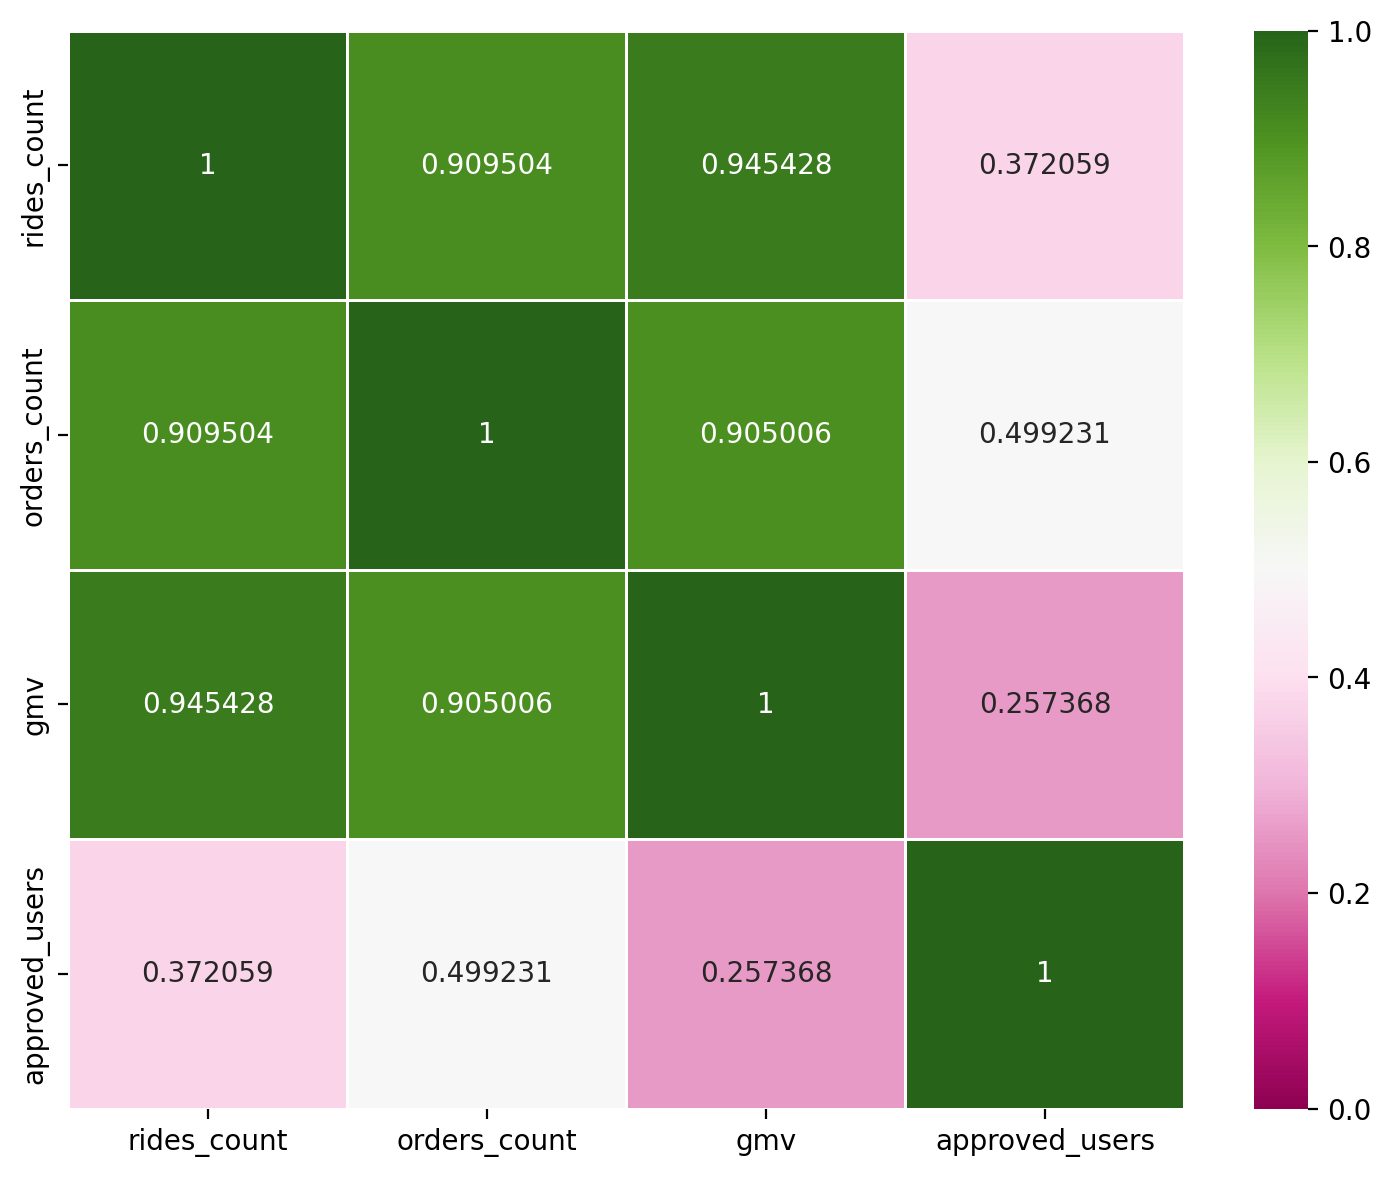

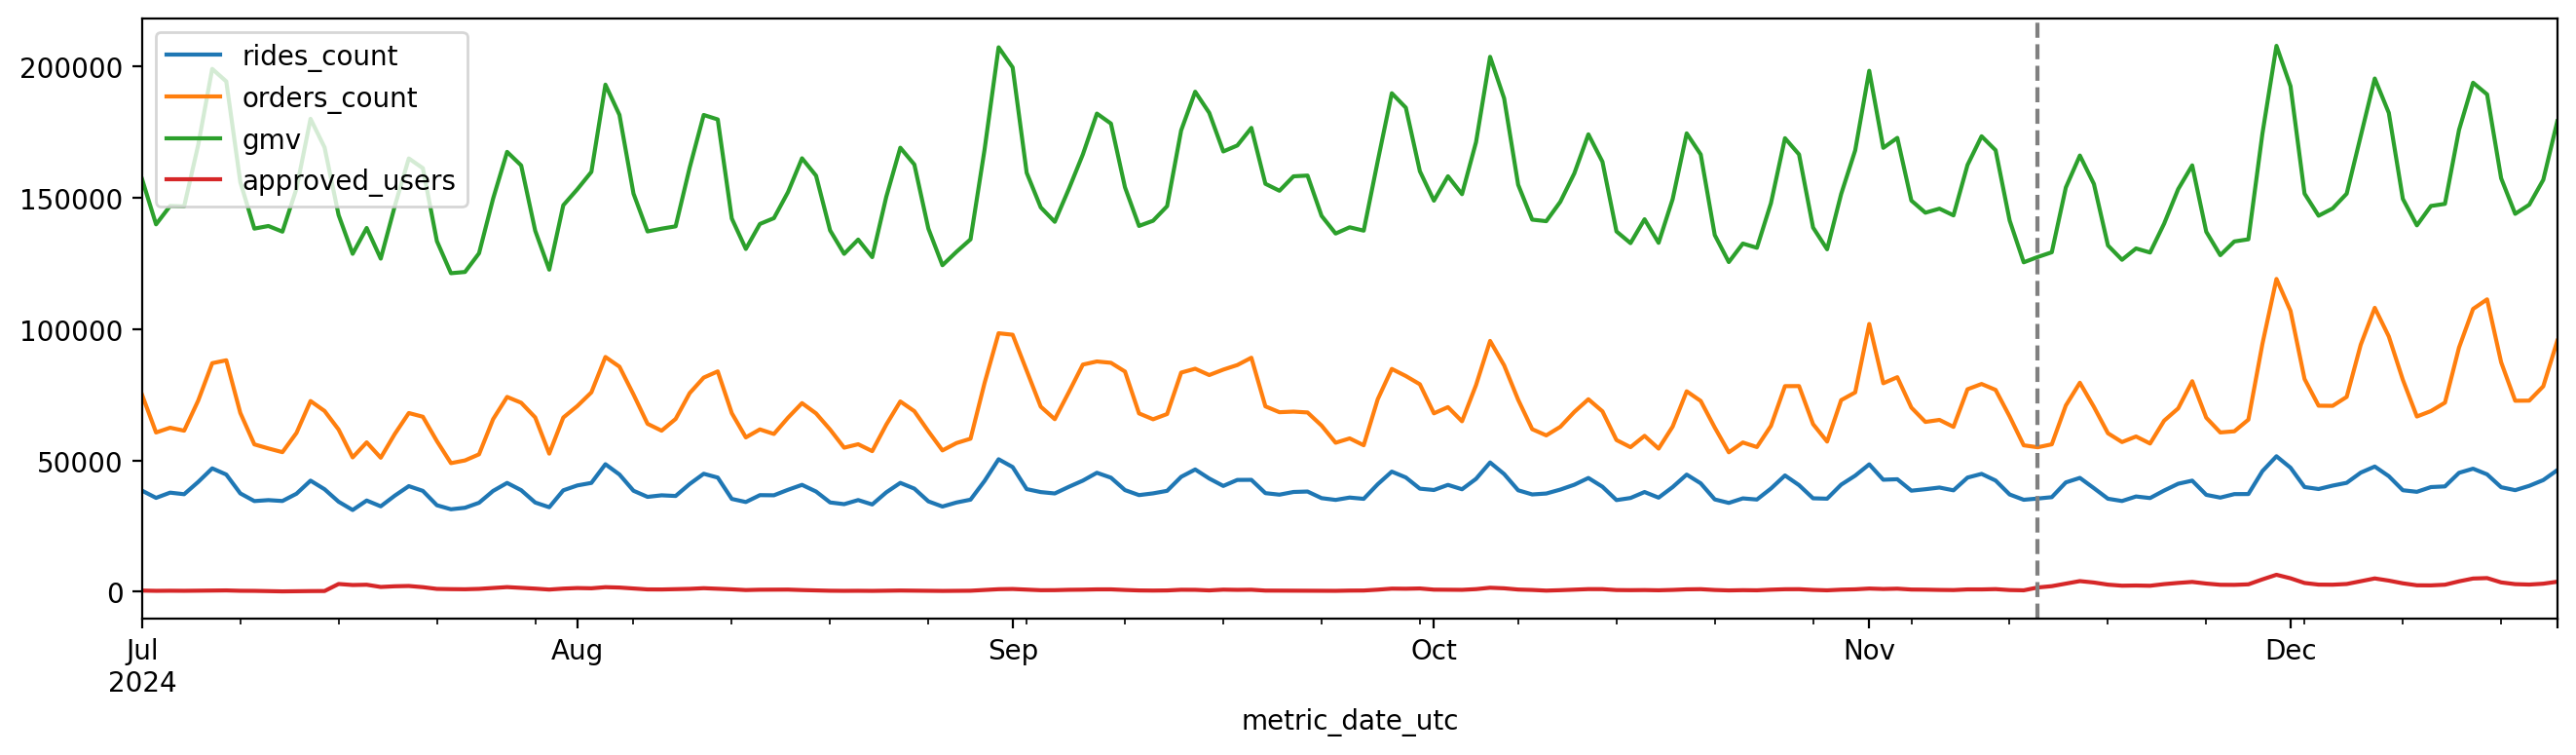

In [89]:
fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(df_result_causal_group_test.corr(), 
            annot=True,
            linewidth=1,
            cmap = "PiYG",
            vmin = 0, vmax = 1,
            square=False,
            annot_kws={"size": 10},
            fmt='g')

plt.figure(figsize = (16, 4))

df_result_causal_group_test['rides_count'].plot(label = 'rides_count')
df_result_causal_group_test['orders_count'].plot(label = 'orders_count')
df_result_causal_group_test['gmv'].plot(label = 'gmv')
df_result_causal_group_test['approved_users'].plot(label = 'approved_users')

plt.legend()
plt.axvline(x='2024-11-13',  color = 'grey', ls = '--')


<Axes: xlabel='gmv', ylabel='rides_count'>

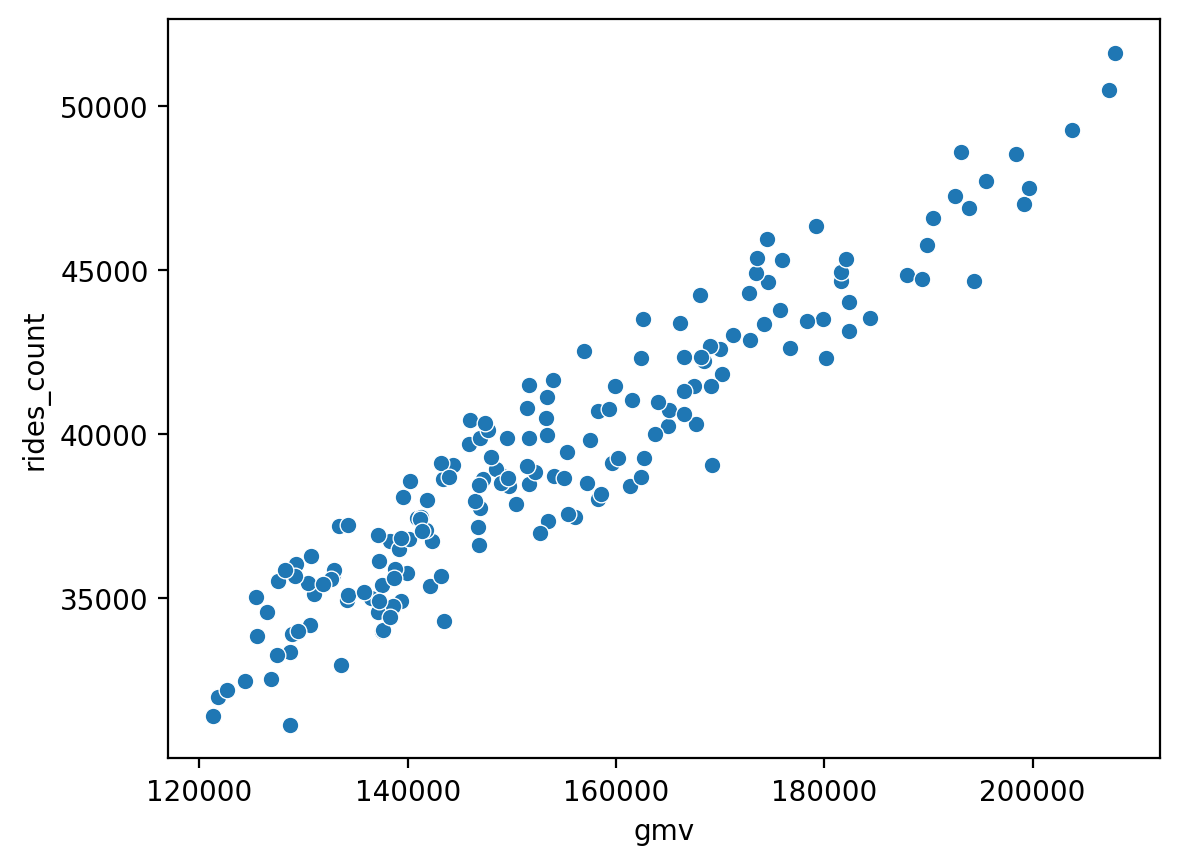

In [90]:
sns.scatterplot(x= df_result_causal_group_test.gmv, y = df_result_causal_group_test.rides_count)

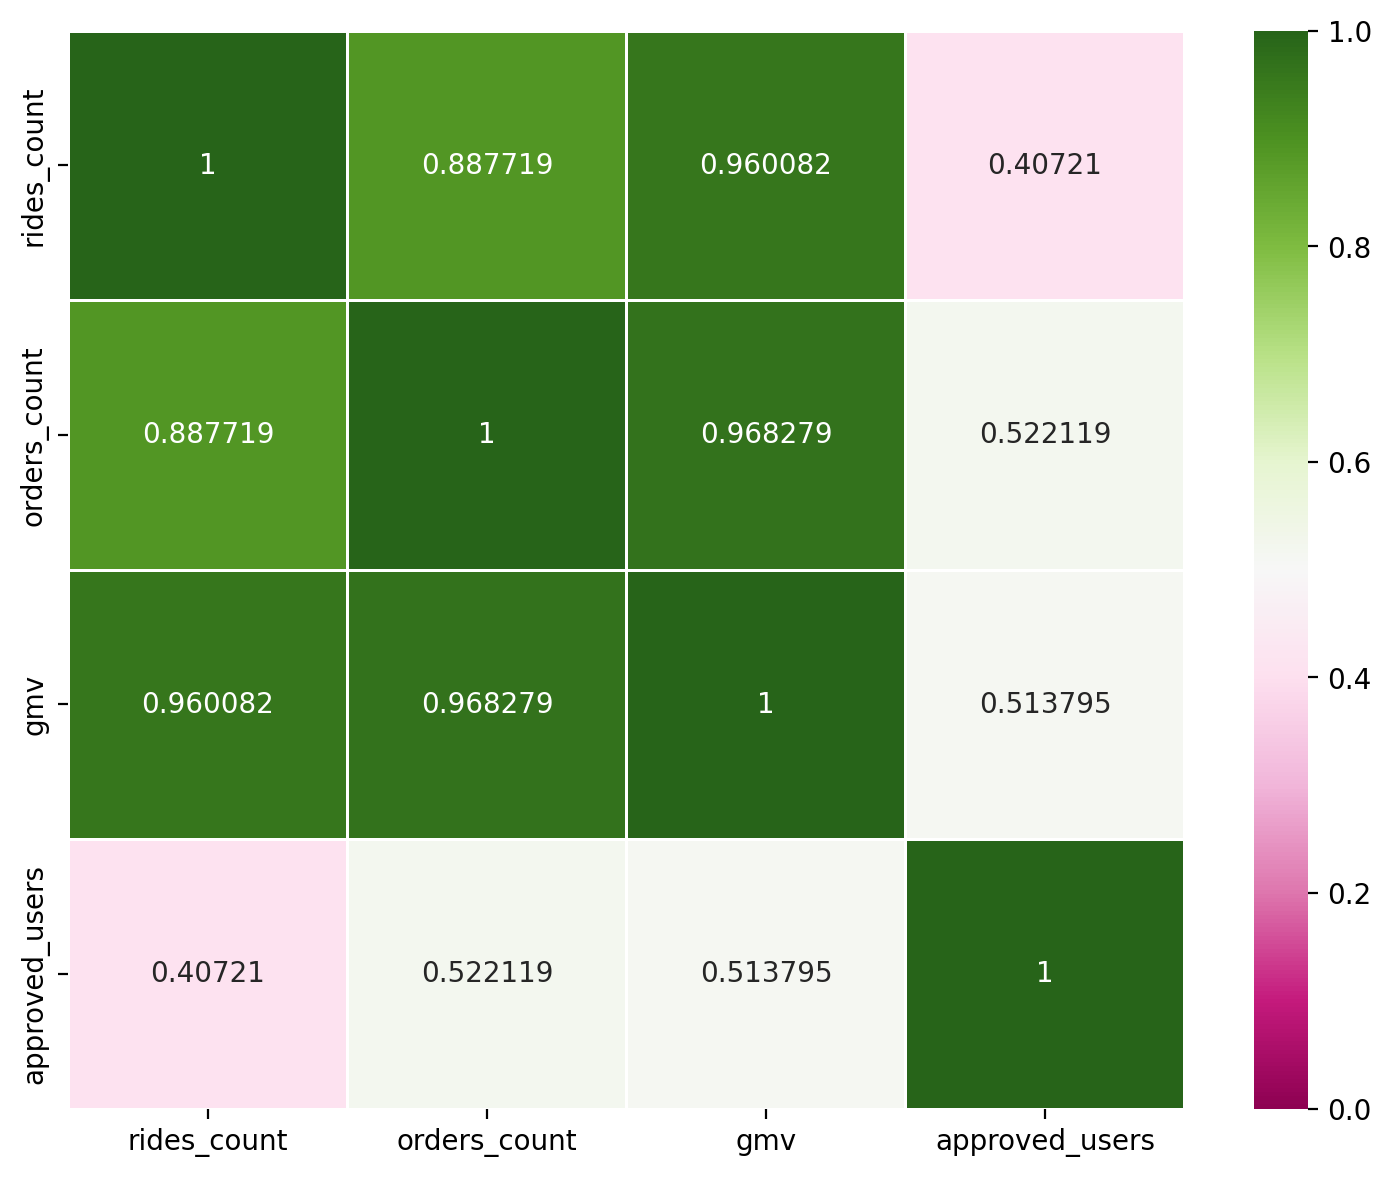

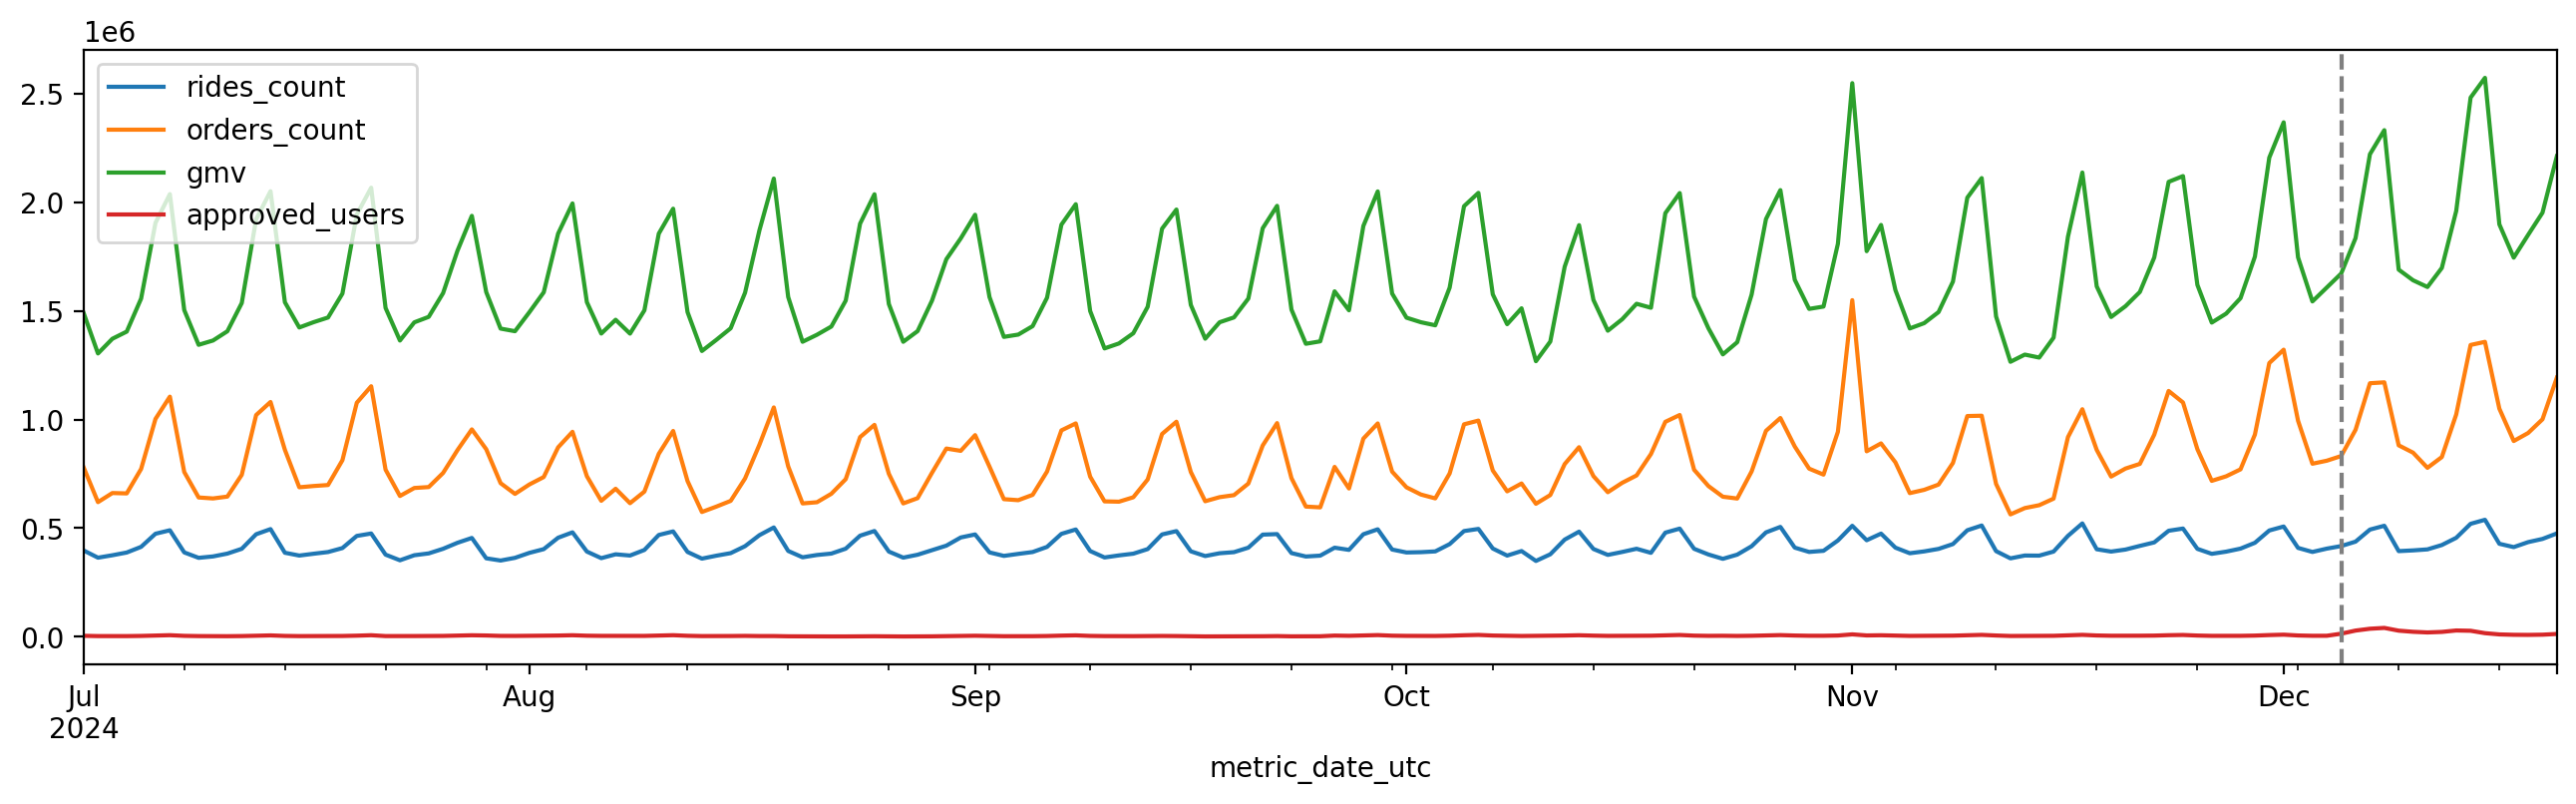

In [91]:
fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(df_result_causal_group_exp.corr(), 
            annot=True,
            linewidth=1,
            cmap = "PiYG",
            vmin = 0, vmax = 1,
            square=False,
            annot_kws={"size": 10},
            fmt='g')

plt.figure(figsize = (16, 4))

df_result_causal_group_exp['rides_count'].plot(label = 'rides_count')
df_result_causal_group_exp['orders_count'].plot(label = 'orders_count')
df_result_causal_group_exp['gmv'].plot(label = 'gmv')
df_result_causal_group_exp['approved_users'].plot(label = 'approved_users')

plt.legend()
plt.axvline(x='2024-12-05',  color = 'grey', ls = '--')


<Axes: xlabel='gmv', ylabel='rides_count'>

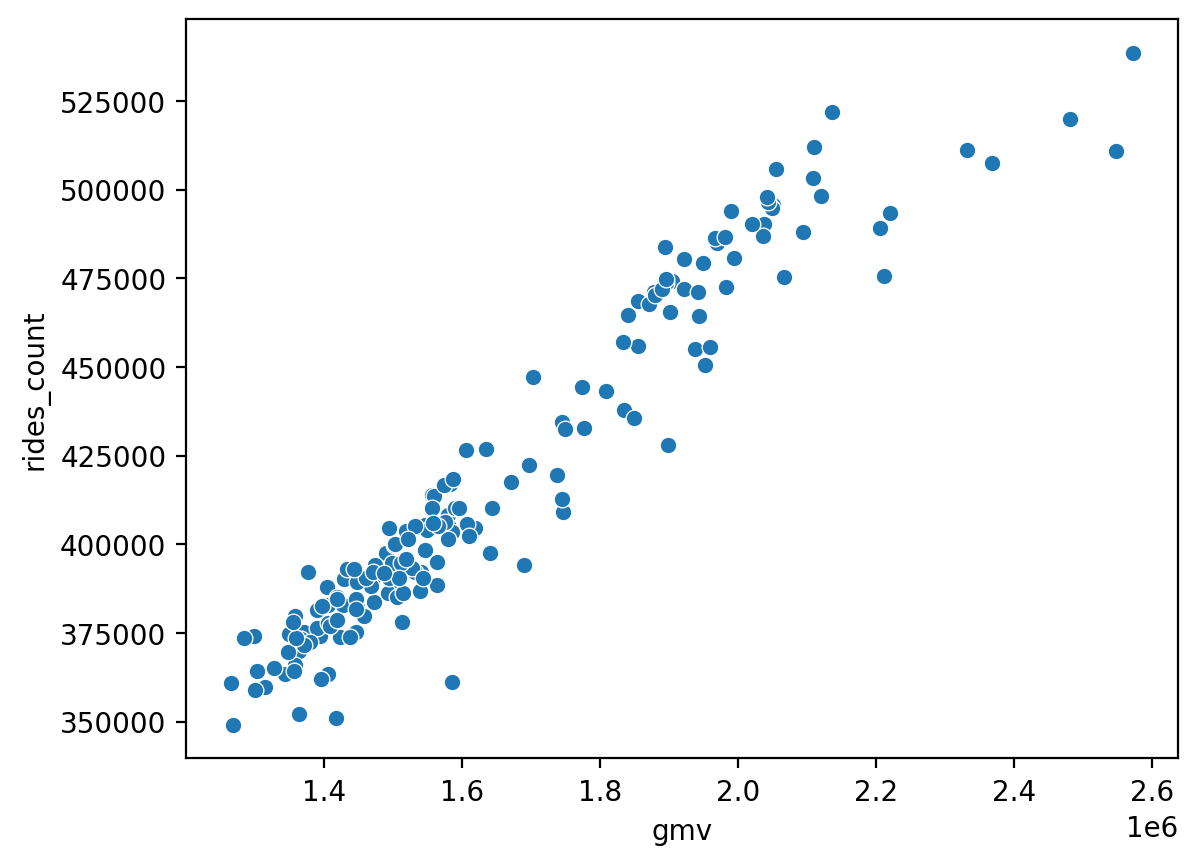

In [92]:
    sns.scatterplot(x= df_result_causal_group_exp.gmv, y = df_result_causal_group_exp.rides_count)


#### Drawing the Causal Impact

##### Test group

/Users/renatyunison/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/renatyunison/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


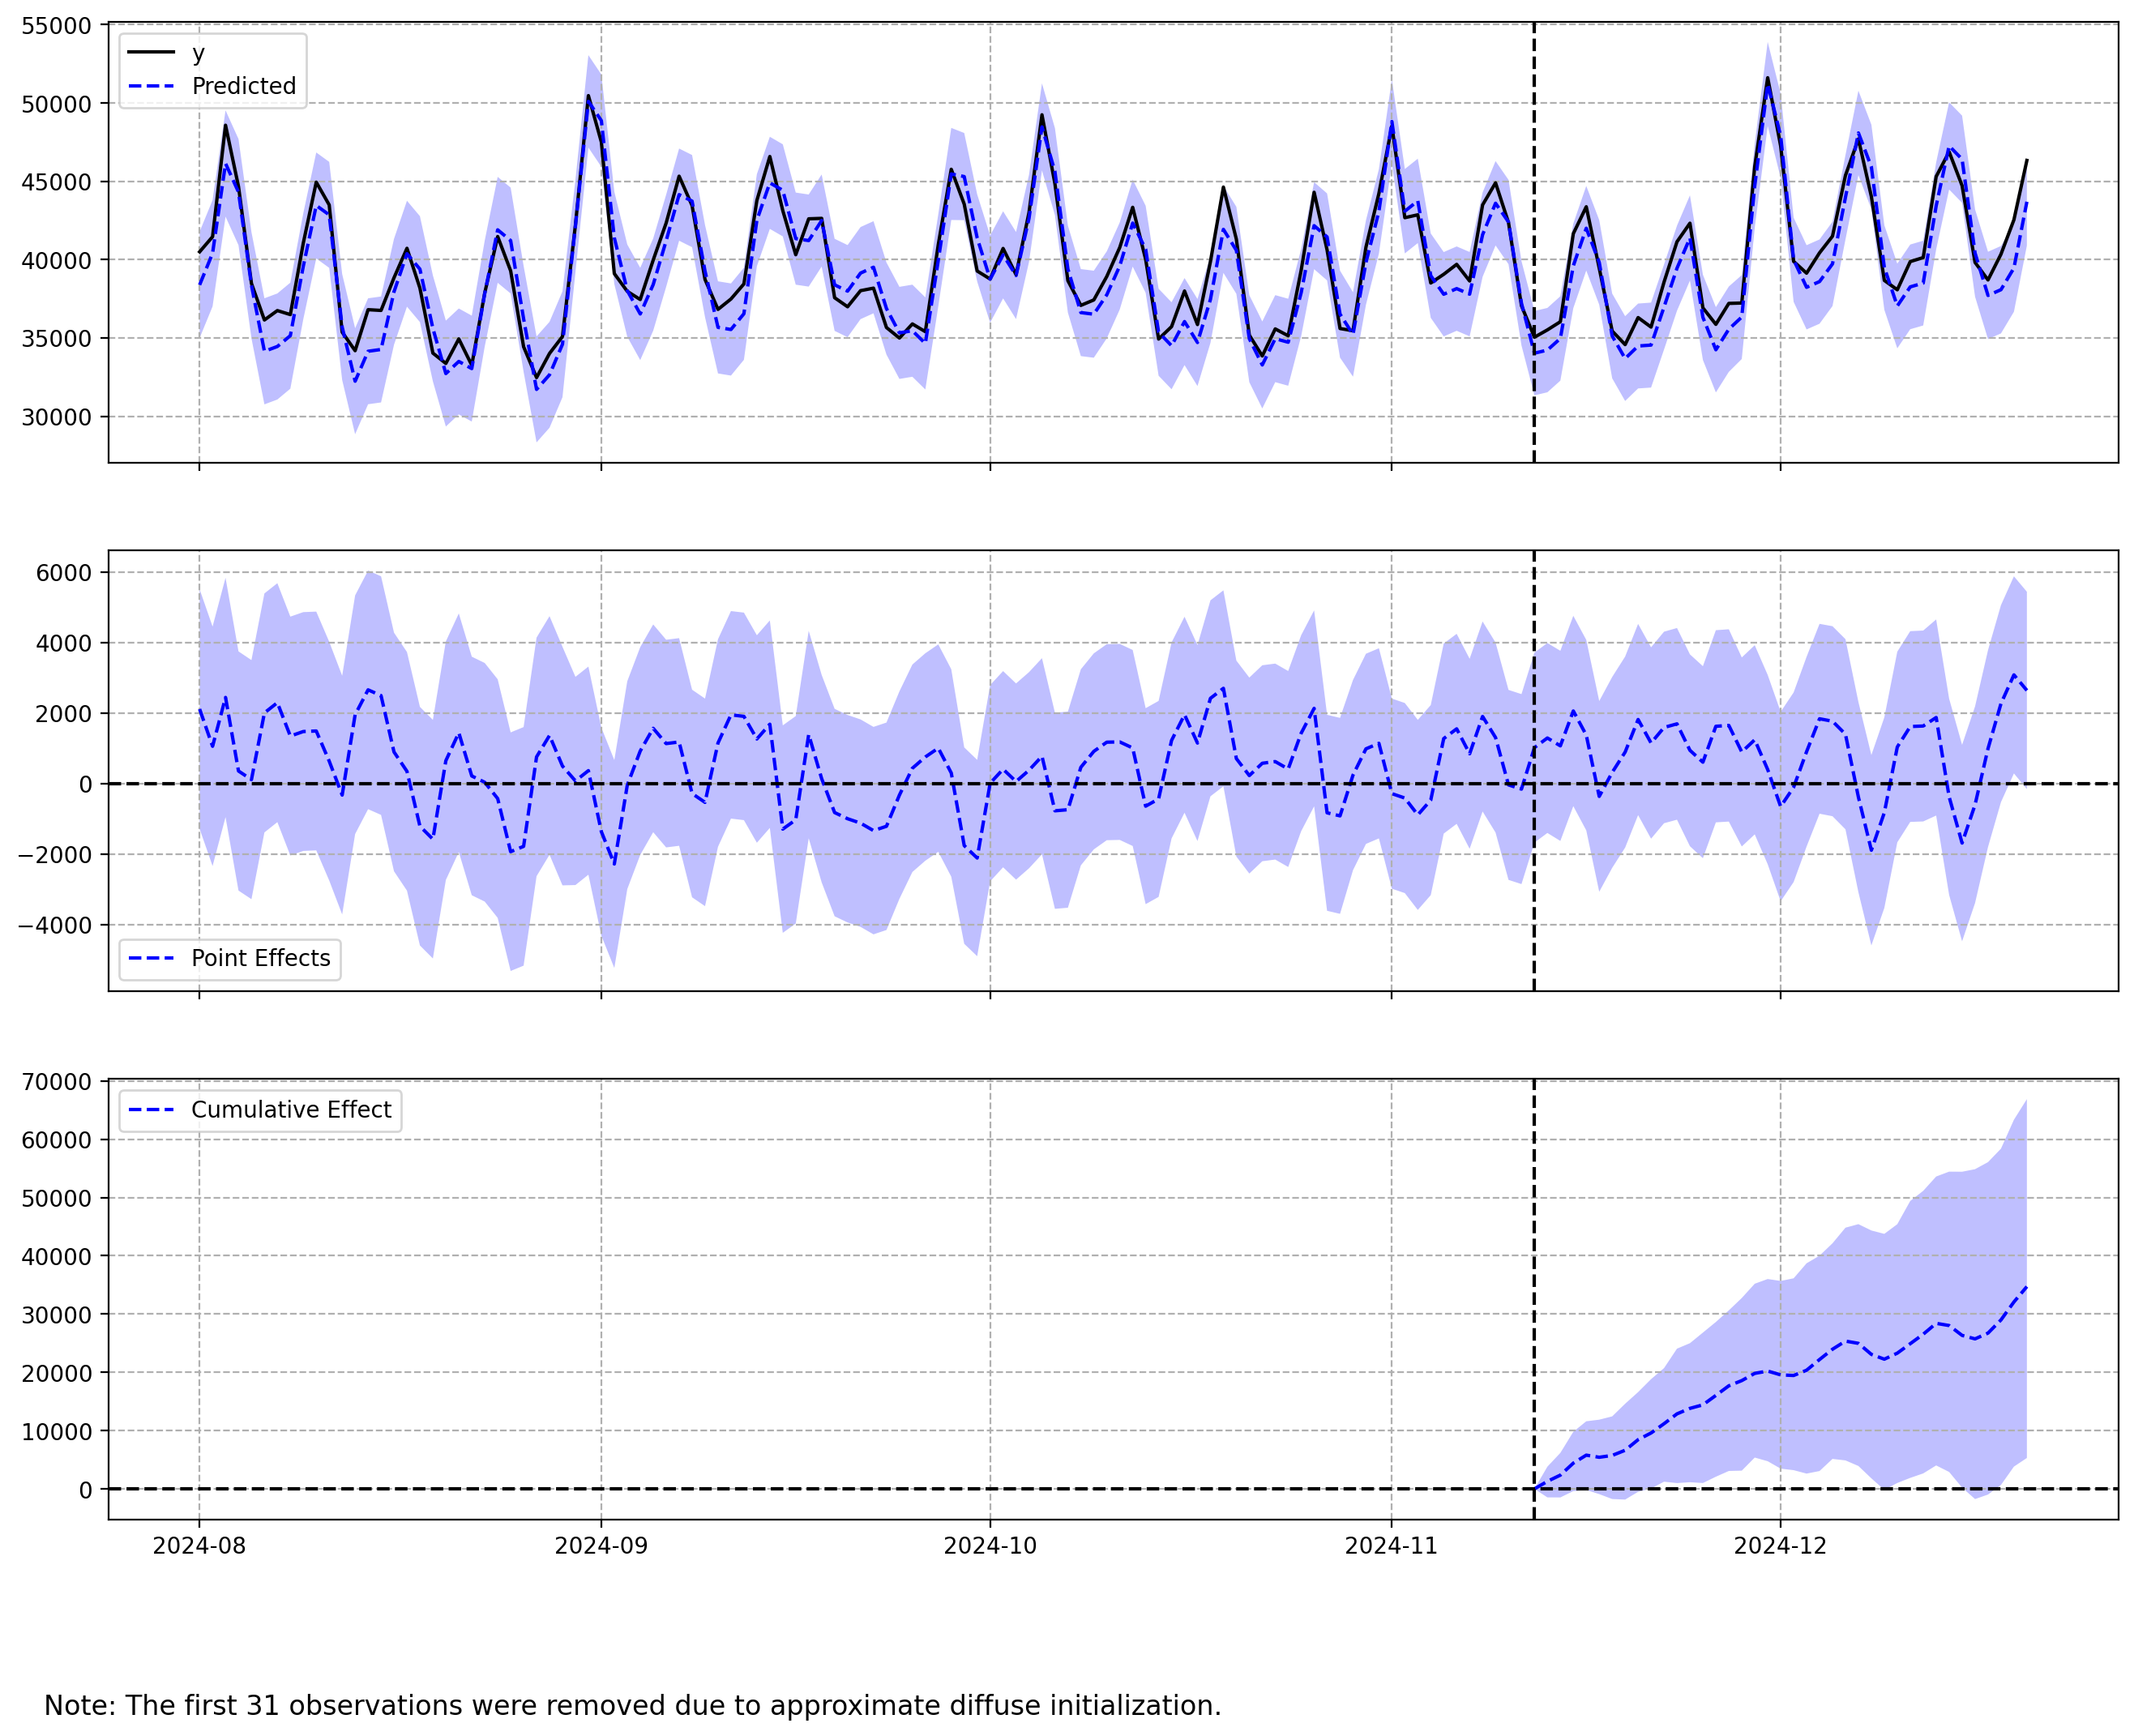

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    40832.26           1551626.0
Prediction (s.d.)         39918.87 (314.53)  1516917.18 (11952.16)
99% CI                    [39072.39, 40692.74][1484750.83, 1546324.3]

Absolute effect (s.d.)    913.39 (314.53)    34708.82 (11952.16)
99% CI                    [139.52, 1759.87]  [5301.7, 66875.17]

Relative effect (s.d.)    2.29% (0.79%)      2.29% (0.79%)
99% CI                    [0.35%, 4.41%]     [0.35%, 4.41%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


In [76]:
ci = CausalImpact(df_result_causal_group_test.astype('float64'), ts_pre_period_test, ts_post_period_test, alpha = 0.01, nseasons=[{'period': 7}])
ci.plot(figsize = (16, 12))
print(ci.summary())

In [81]:
ci_data = ci.data.merge(ci.inferences, left_index = True, right_index = True)
ci_data_pre = ci_data.loc[ts_pre_period_test[0]:ts_pre_period_test[-1], :]

mae = mean_absolute_error(ci_data_pre.rides_count, ci_data_pre.preds)
mape = mean_absolute_percentage_error(ci_data_pre.rides_count, ci_data_pre.preds)
r2 = r2_score(ci_data_pre.rides_count, ci_data_pre.preds)

print('MAE =', round(mae, 3))
#print('MAE =', round(ci_data_pre.point_effects.abs().mean(), 3))
print('MAPE =', round(mape, 3))
print('R2_score =', r2)
print('Mean residuals =', ci_data_pre.point_effects.mean())


MAE = 1036.388
MAPE = 0.027
R2_score = 0.9073764729053119
Mean residuals = 177.539465148444


p-value Dickey-Fuller = 0.104978
p-value Student test = 0.096351
p-value Ljung-Box test = 0.000000


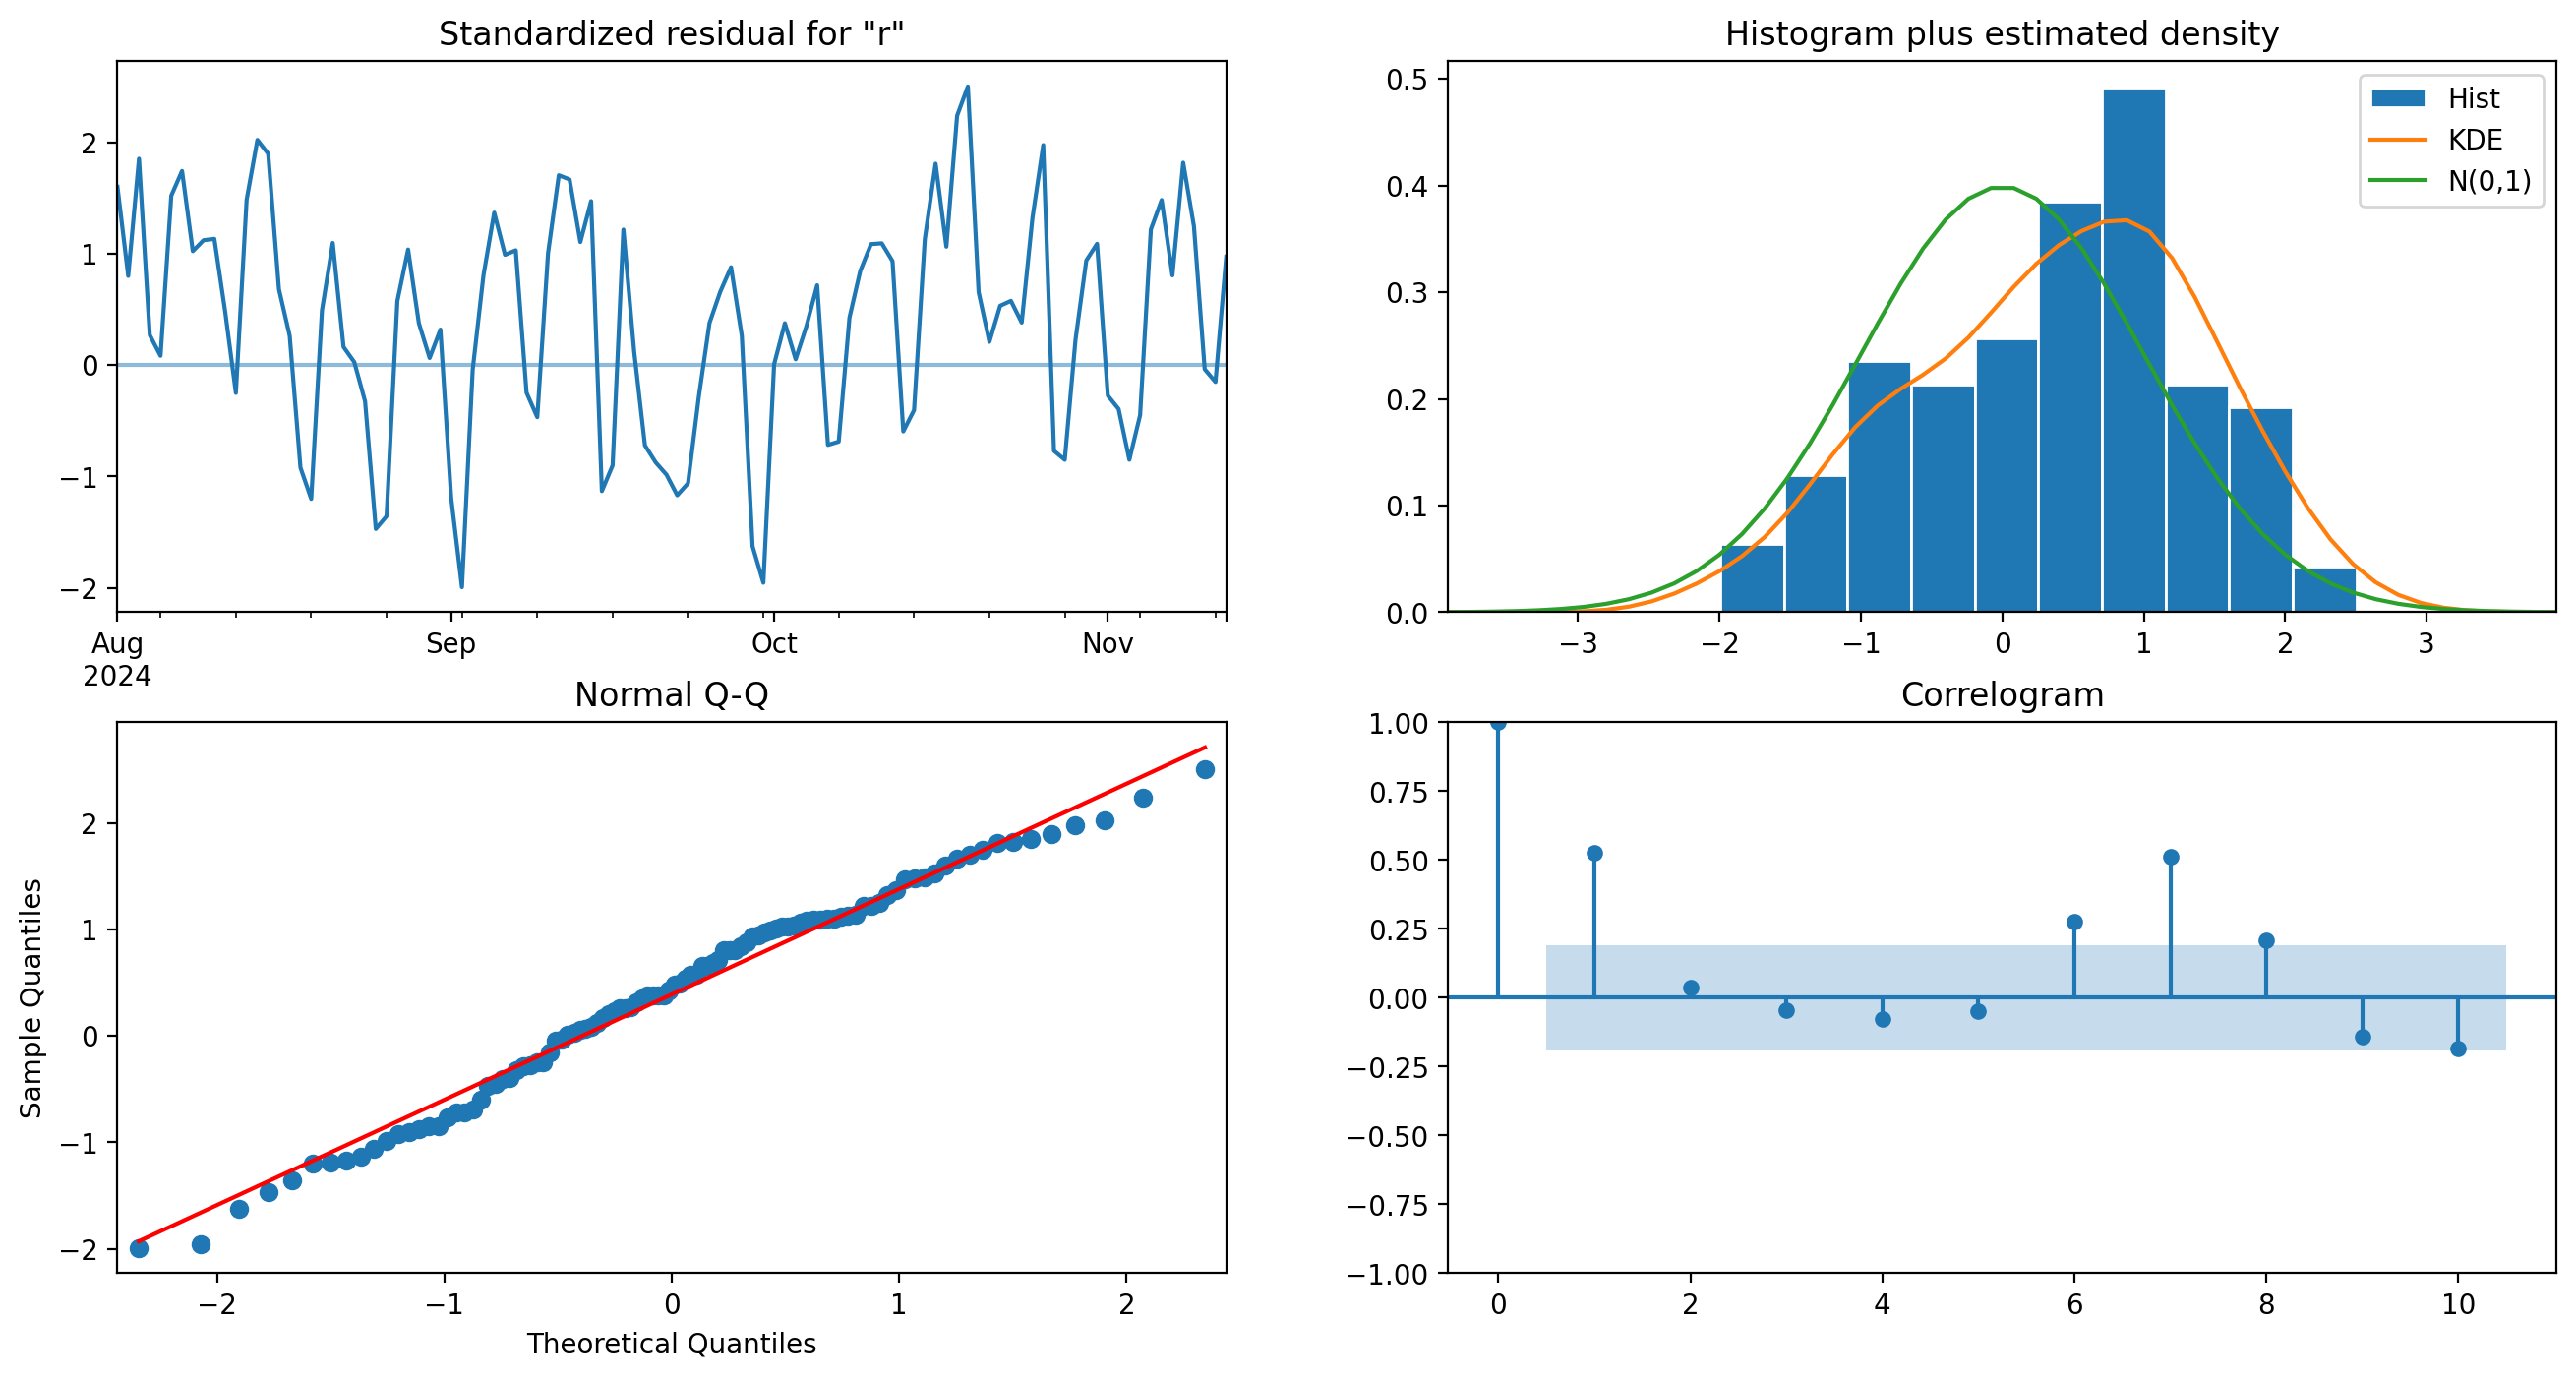

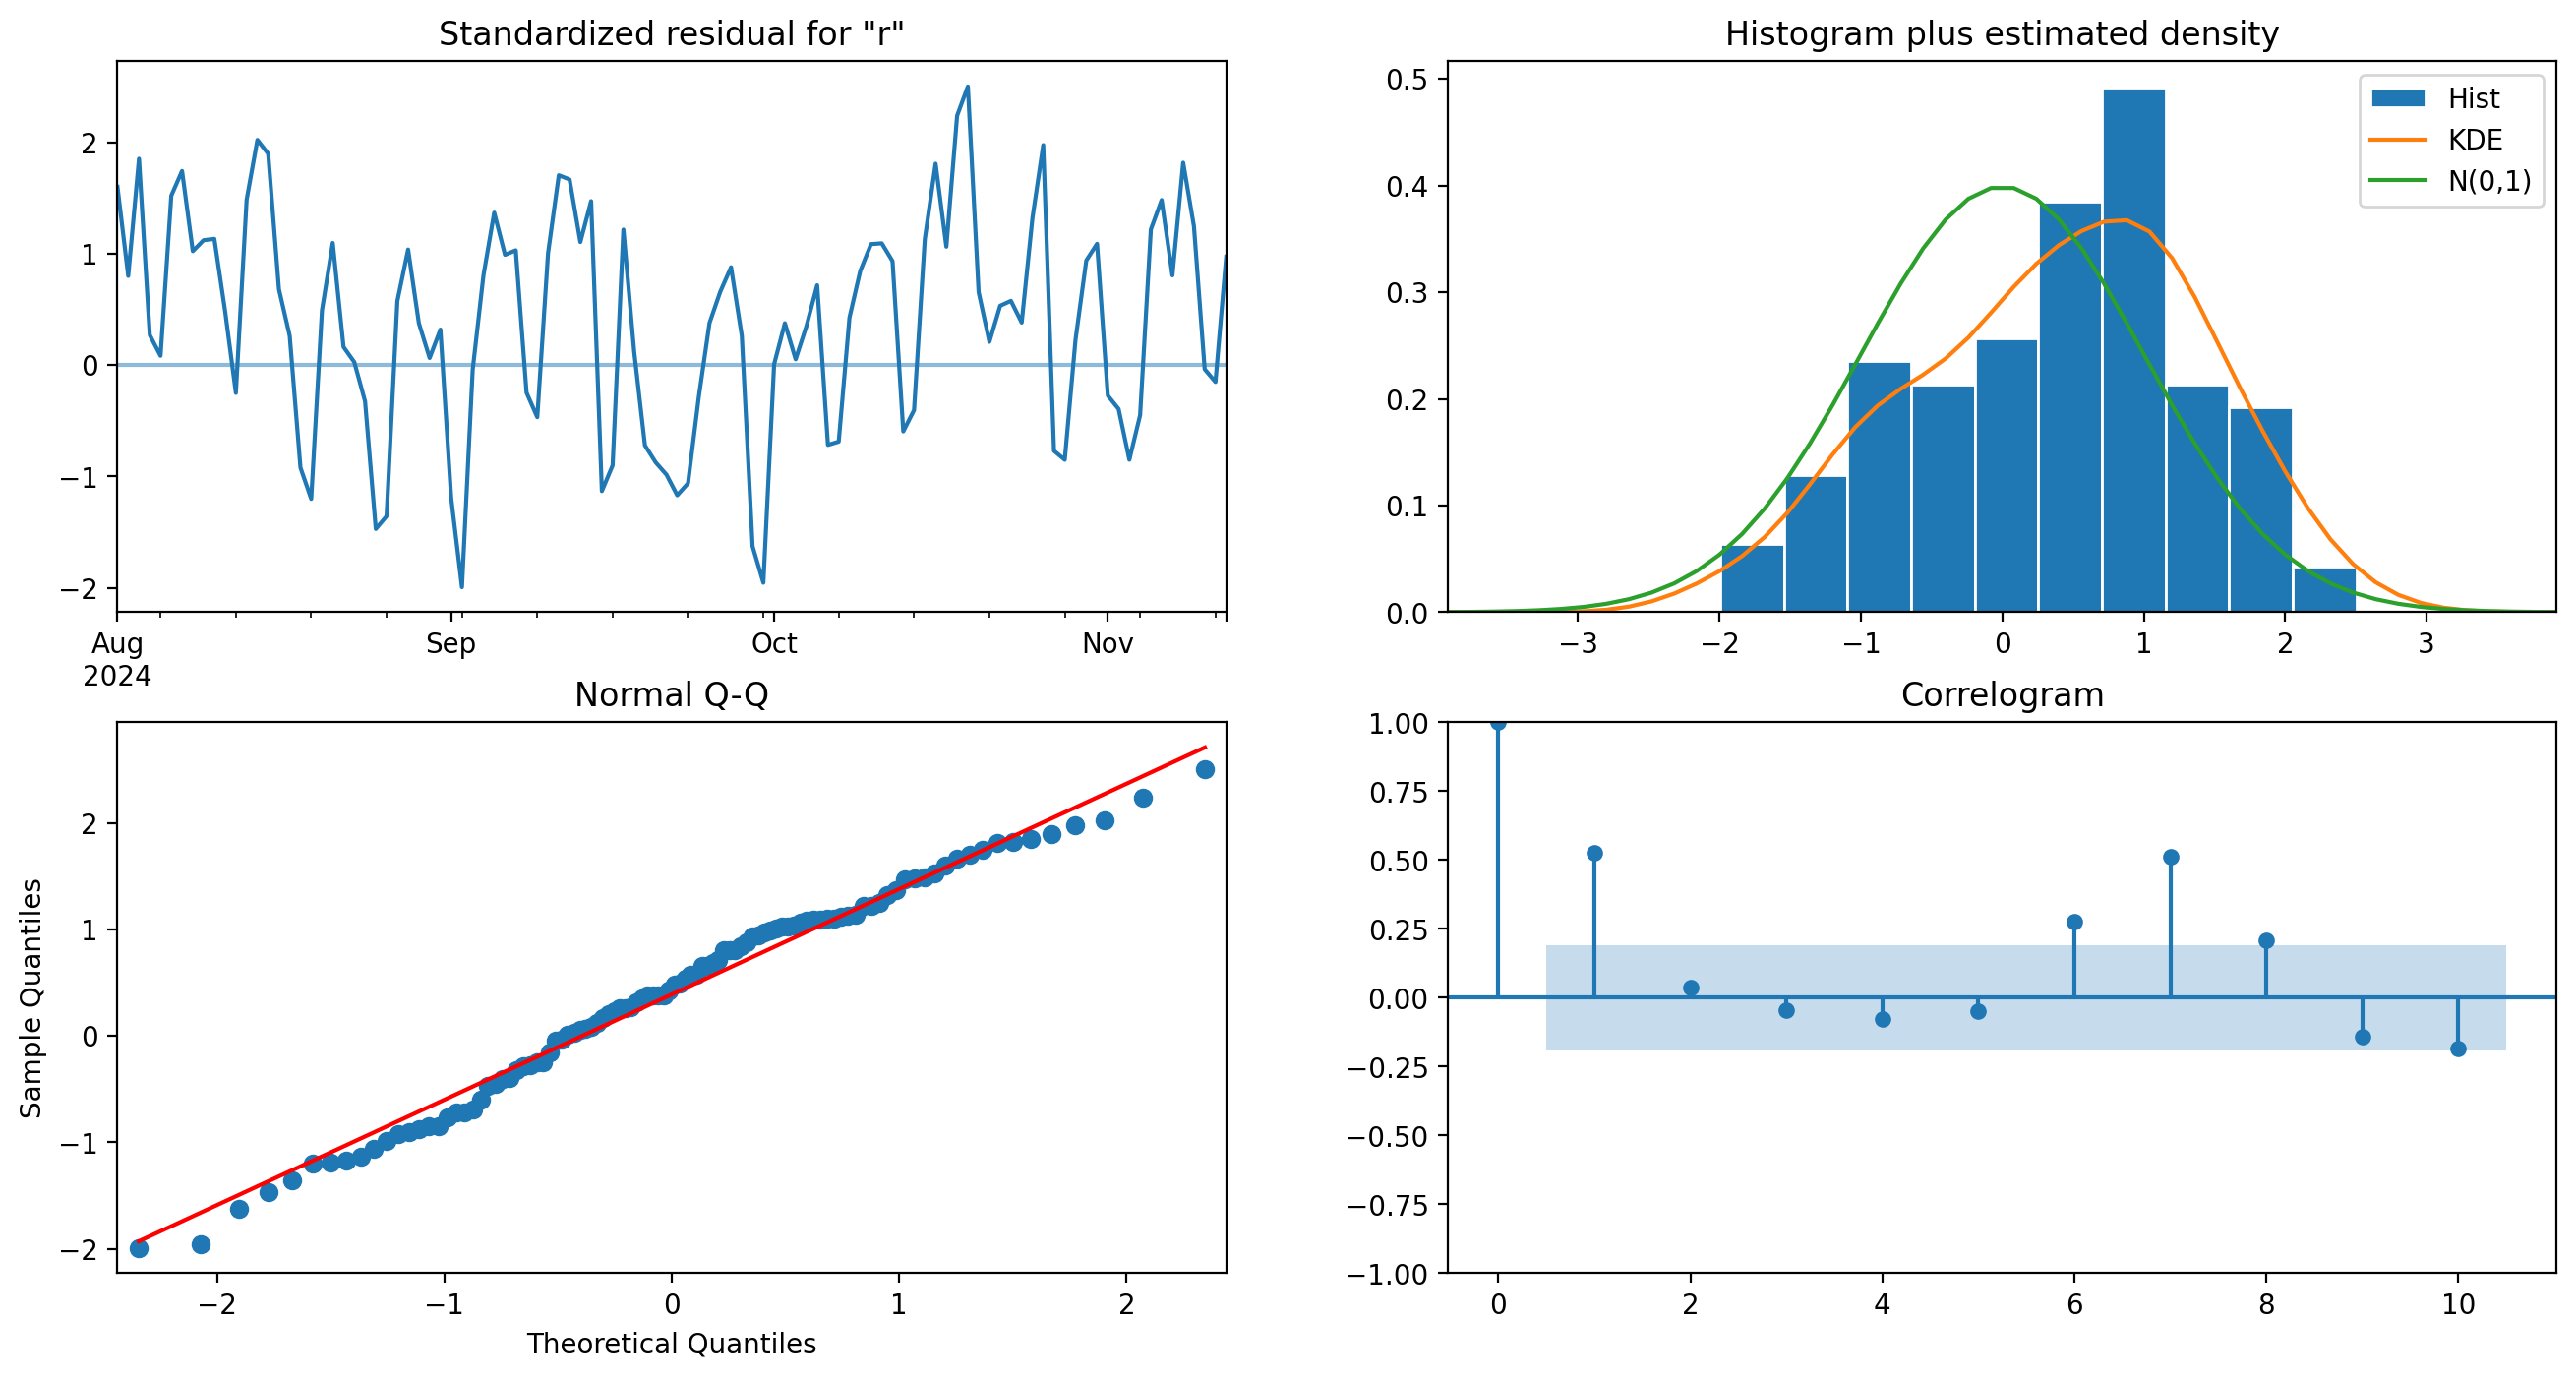

In [83]:
print("p-value Dickey-Fuller = %f" % sm.tsa.stattools.adfuller(ci.trained_model.resid)[1])
print("p-value Student test = %f" % ttest_1samp(ci.trained_model.resid, 0)[1])
print("p-value Ljung-Box test = %f" % ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci.trained_model.plot_diagnostics(figsize = (16, 8))

##### Experiment group

/Users/renatyunison/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/renatyunison/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


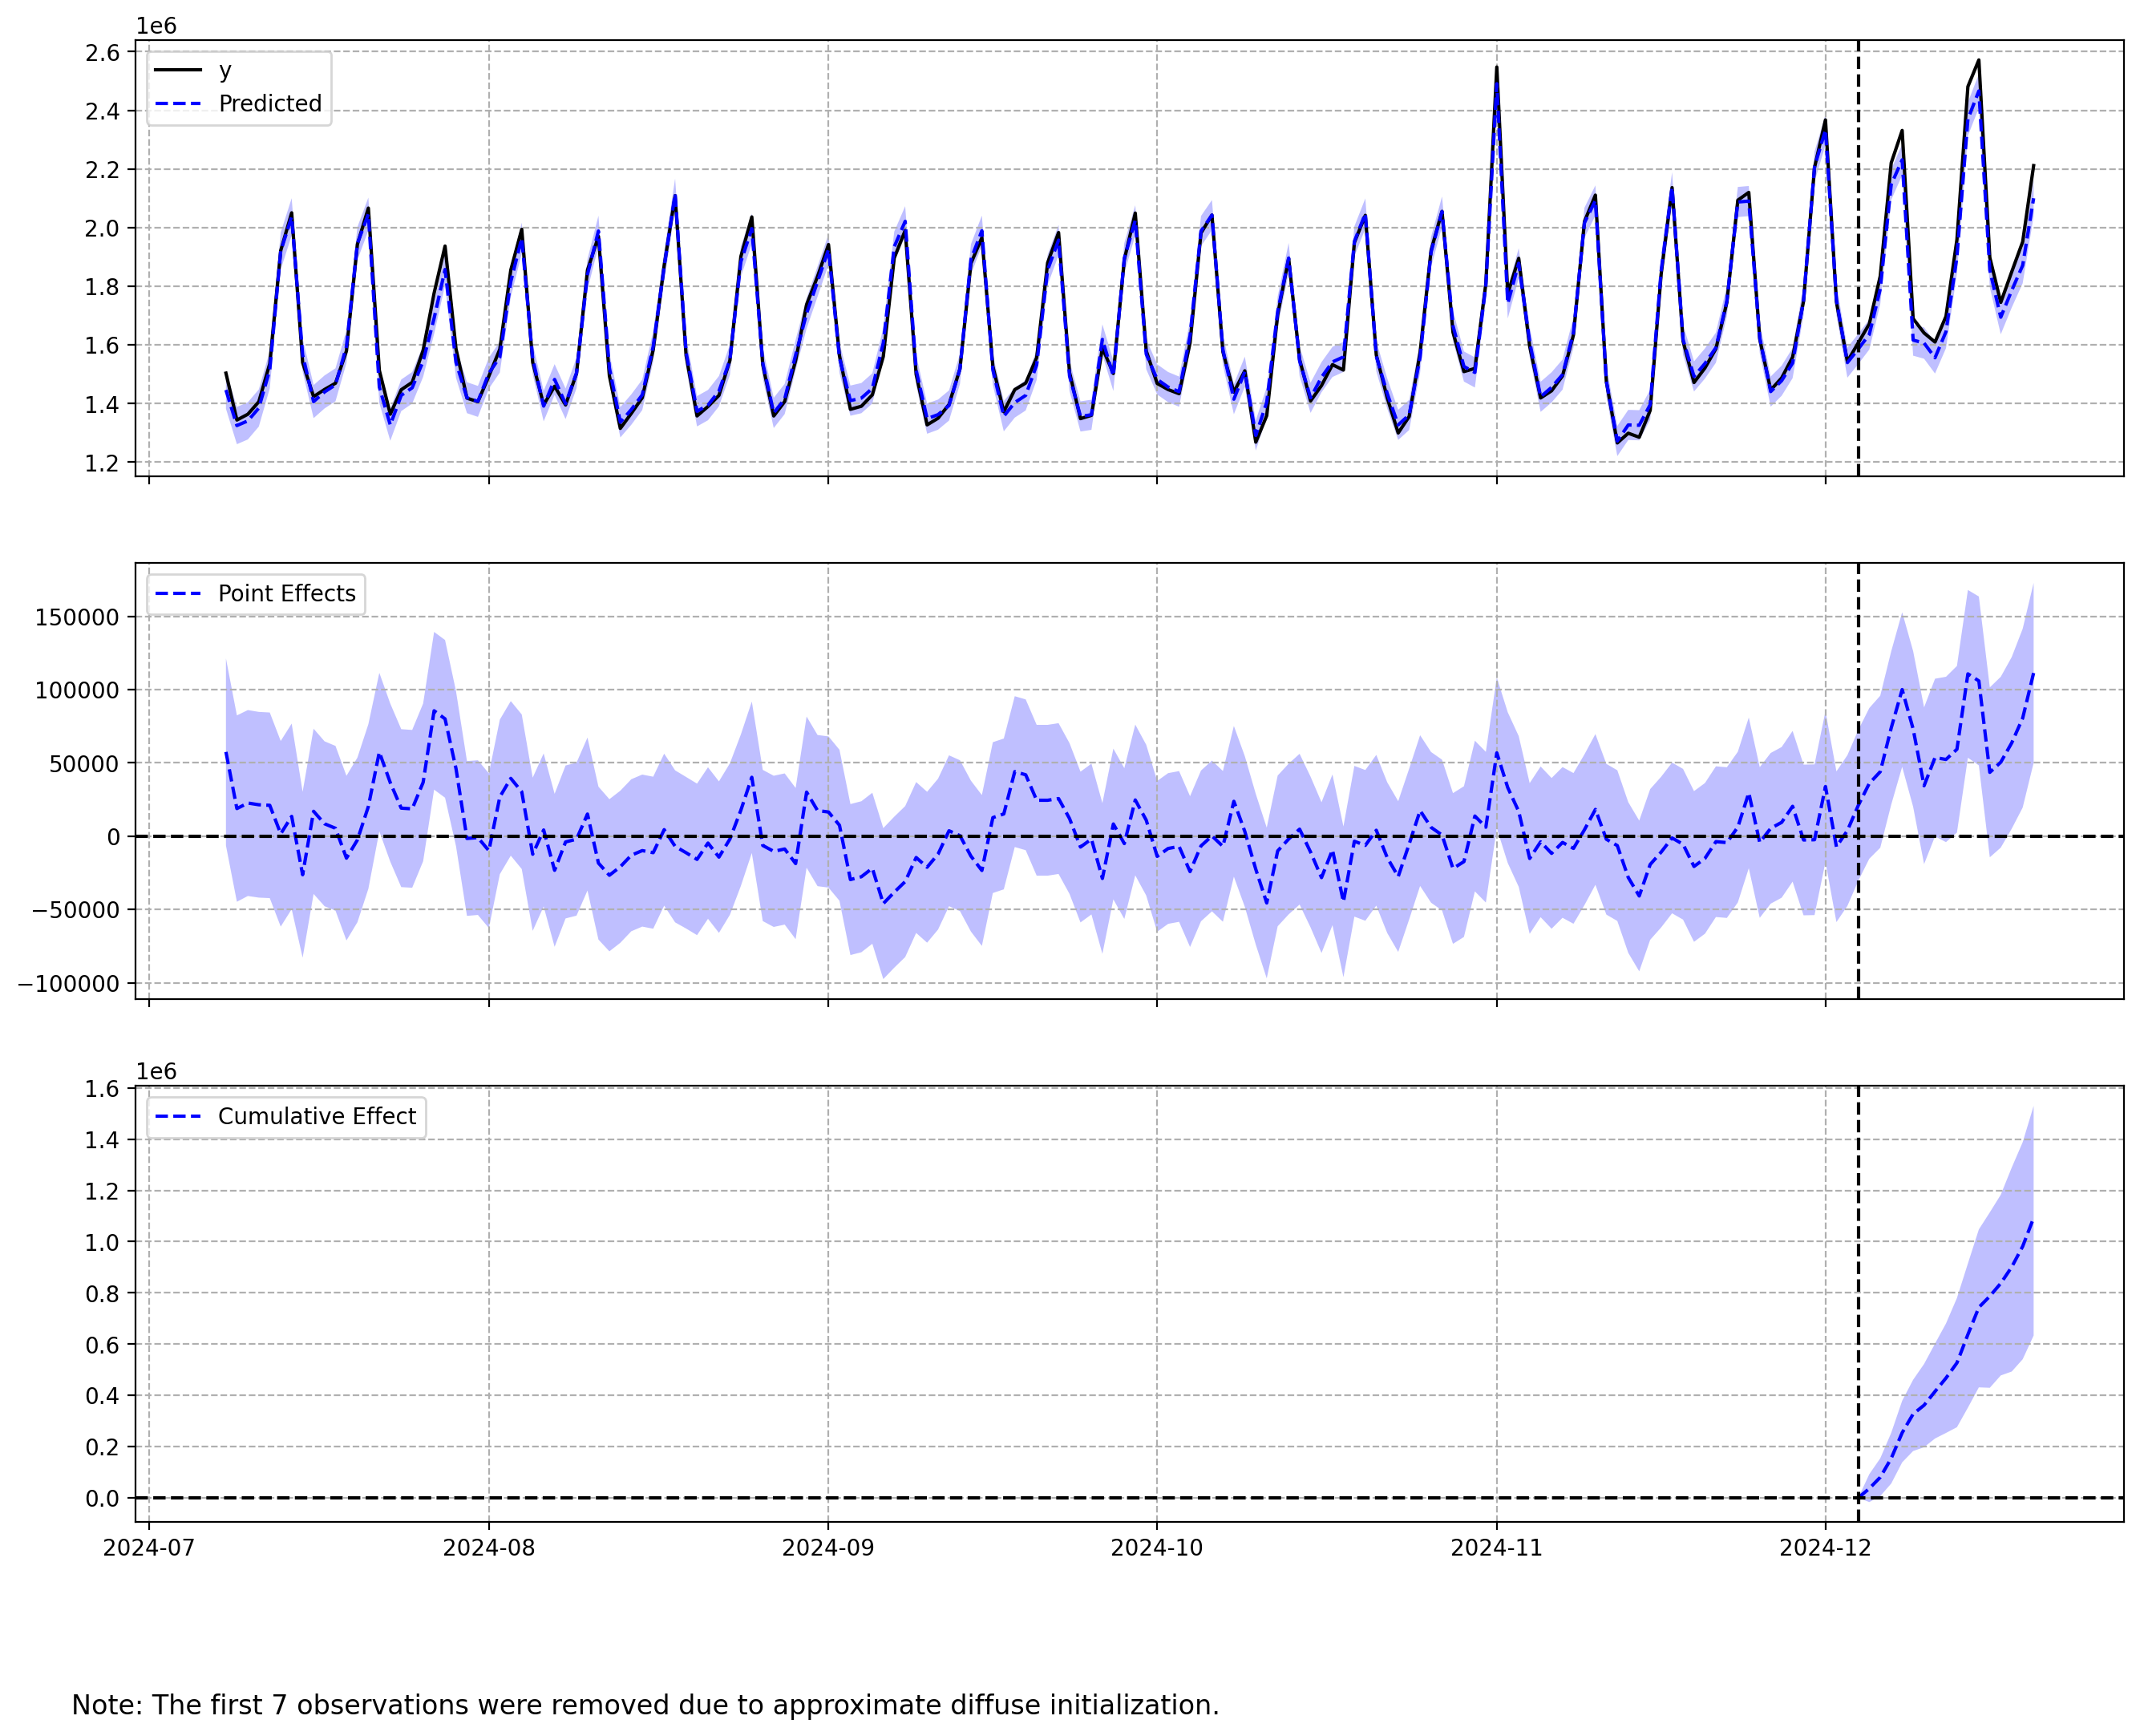

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1960218.51         31363496.22
Prediction (s.d.)         1891909.63 (10879.02)30270554.09 (174064.37)
99% CI                    [1864589.75, 1920634.76][29833435.94, 30730156.14]

Absolute effect (s.d.)    68308.88 (10879.02)1092942.13 (174064.37)
99% CI                    [39583.75, 95628.77][633340.07, 1530060.27]

Relative effect (s.d.)    3.61% (0.58%)      3.61% (0.58%)
99% CI                    [2.09%, 5.05%]     [2.09%, 5.05%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [106]:
ci = CausalImpact(df_result_causal_group_exp[['gmv', 'rides_count', 'orders_count']].astype('float64'), ts_pre_period_exp, ts_post_period_exp, alpha = 0.01, nseasons=[{'period': 7}])
ci.plot(figsize = (16, 12))
print(ci.summary())

In [94]:
ci_data = ci.data.merge(ci.inferences, left_index = True, right_index = True)
ci_data_pre = ci_data.loc[ts_pre_period_test[0]:ts_pre_period_test[-1], :]

mae = mean_absolute_error(ci_data_pre.rides_count, ci_data_pre.preds)
mape = mean_absolute_percentage_error(ci_data_pre.rides_count, ci_data_pre.preds)
r2 = r2_score(ci_data_pre.rides_count, ci_data_pre.preds)

print('MAE =', round(mae, 3))
print('MAPE =', round(mape, 3))
print('R2_score =', r2)
print('Mean residuals =', ci_data_pre.point_effects.mean())


MAE = 8361.516
MAPE = 0.02
R2_score = 0.9434858585171799
Mean residuals = -103.91331411217365


p-value Dickey-Fuller = 0.086868
p-value Student test = 0.999003
p-value Ljung-Box test = 0.000000


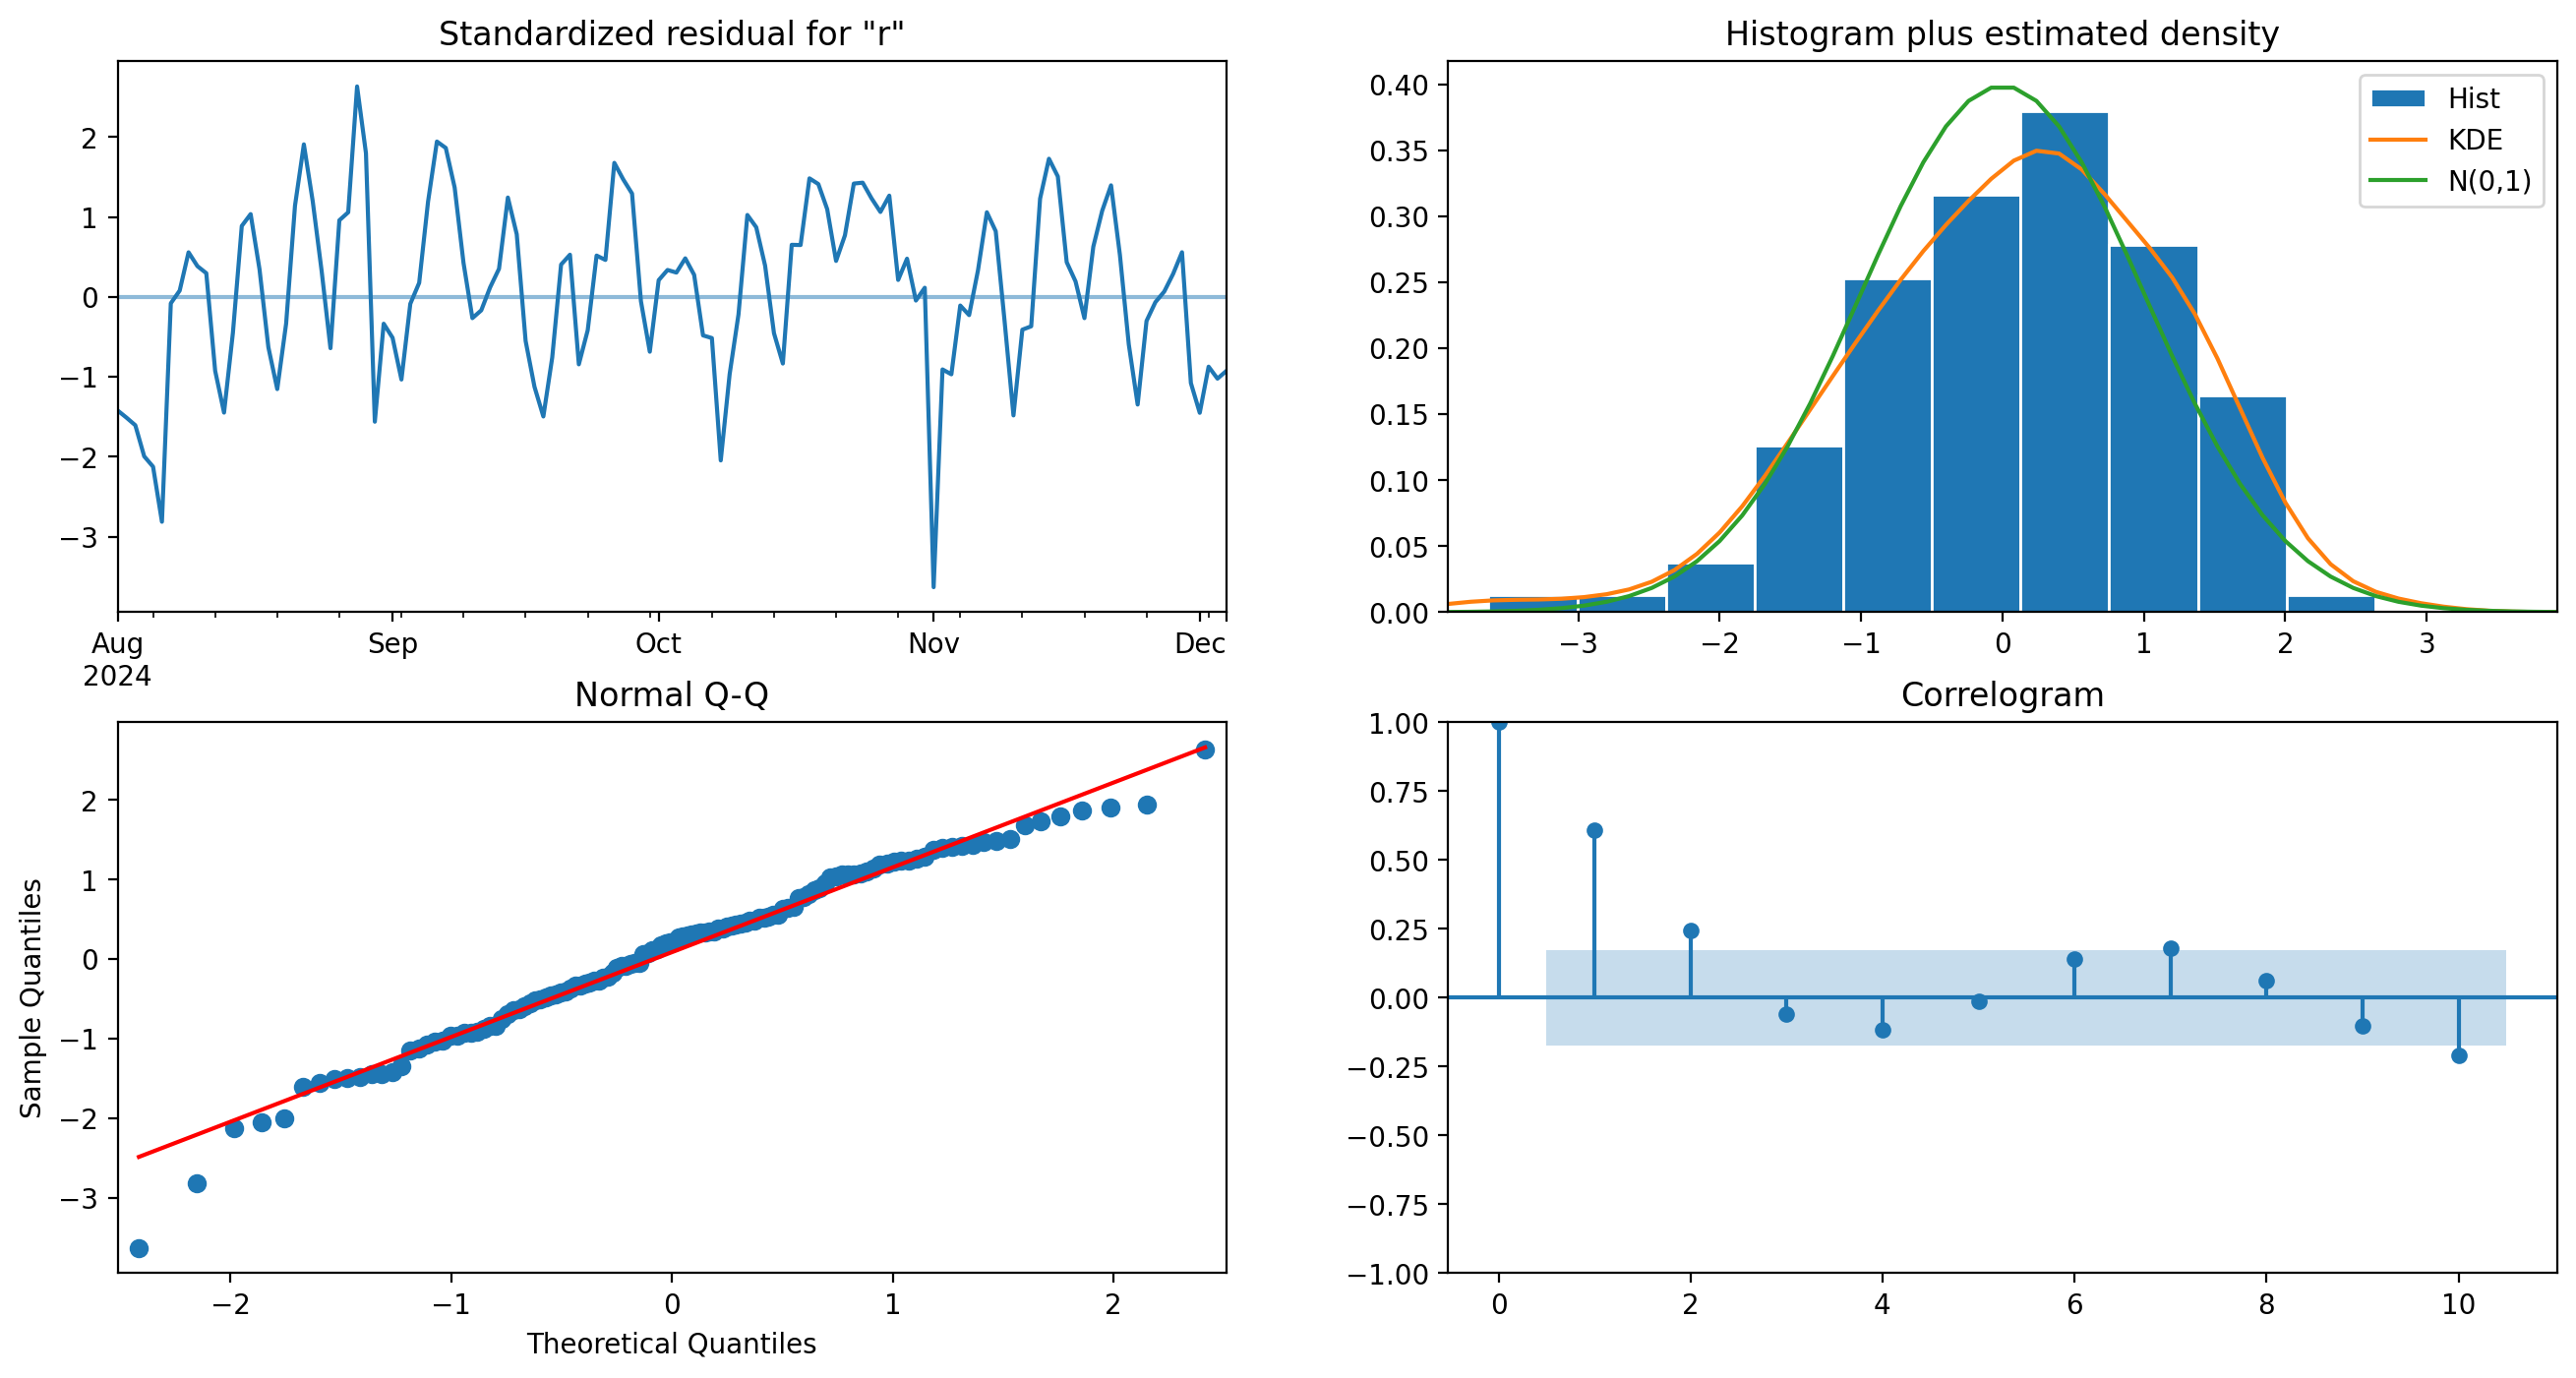

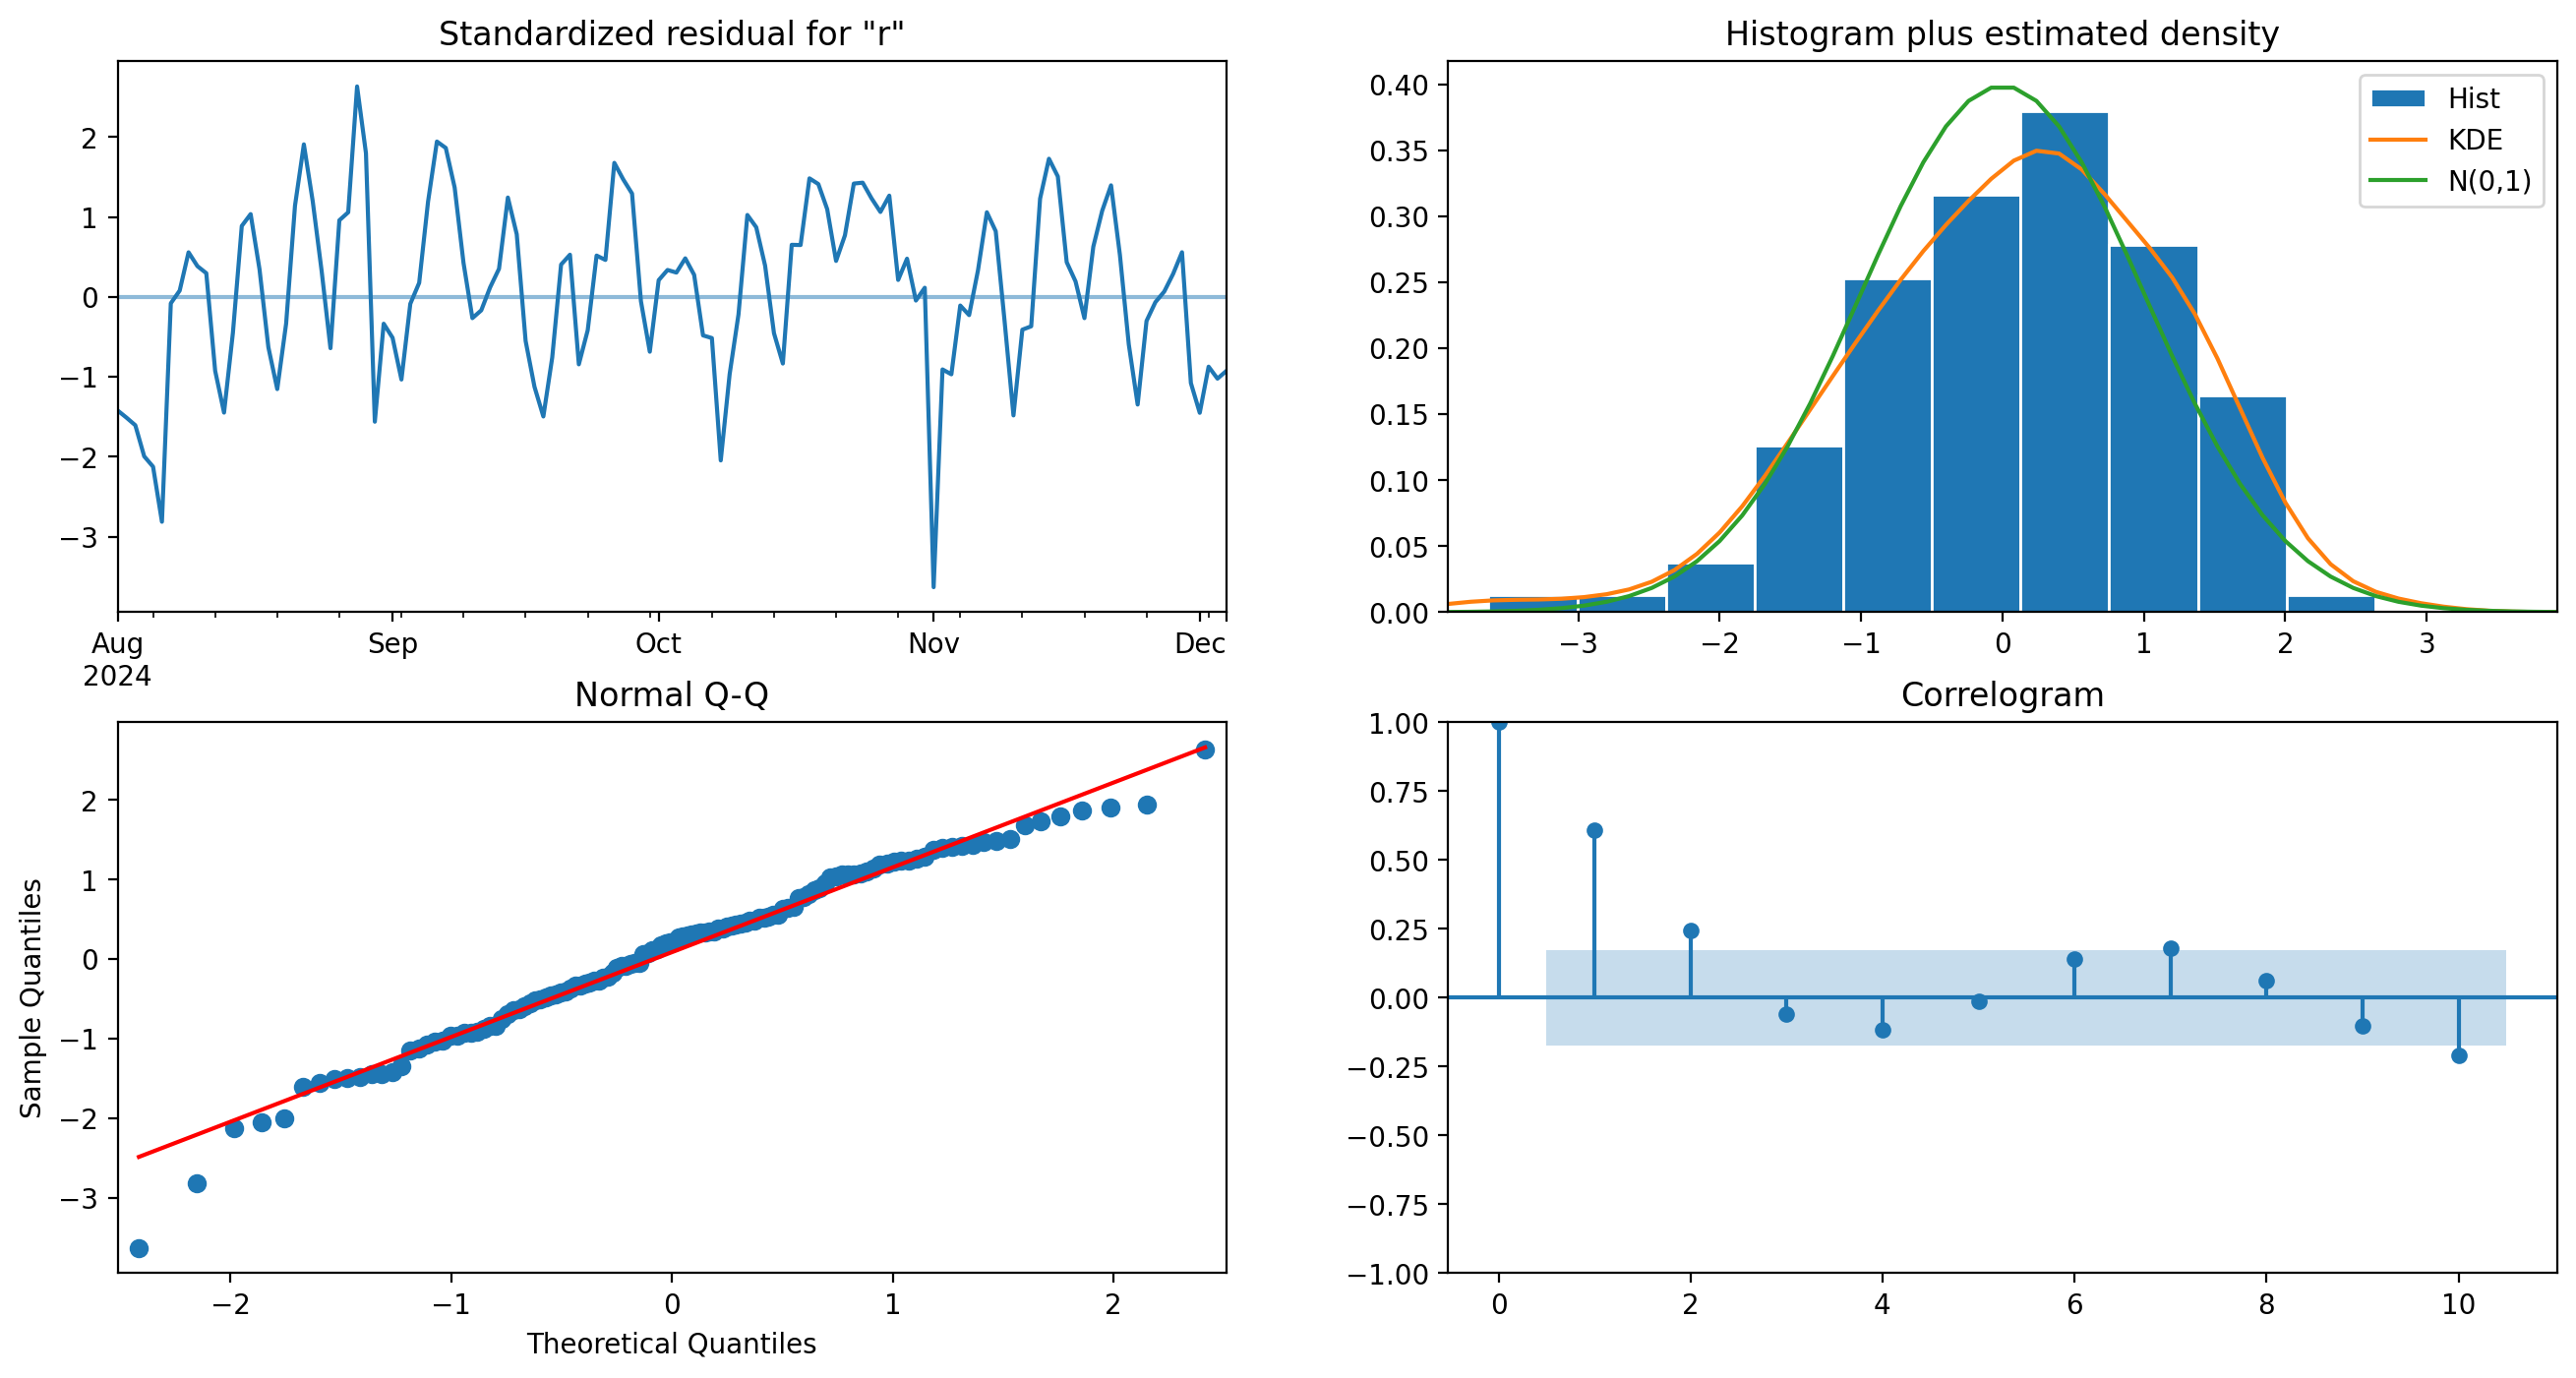

In [95]:
print("p-value Dickey-Fuller = %f" % sm.tsa.stattools.adfuller(ci.trained_model.resid)[1])
print("p-value Student test = %f" % ttest_1samp(ci.trained_model.resid, 0)[1])
print("p-value Ljung-Box test = %f" % ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci.trained_model.plot_diagnostics(figsize = (16, 8))